# Sciplex Dose

In [1]:
ood_seed = 13

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('SAHA', '100.0'), 419)

Removed datapoint: 419


In [10]:
adata

AnnData object with n_obs × n_vars = 14392 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed_expression-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1723,1548,1455,1748,1439,1528,1436,637
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1564,3576,2196,2455,1723
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 432,413,337,423,351,412,331,179
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 375,892,564,615,432
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:14<2:21:45, 14.20s/it]

Epoch 1/600:   0%|          | 1/600 [00:14<2:21:45, 14.20s/it, v_num=1, total_loss_train=2.67e+3, kl_local_train=43.4]

Epoch 2/600:   0%|          | 1/600 [00:14<2:21:45, 14.20s/it, v_num=1, total_loss_train=2.67e+3, kl_local_train=43.4]

Epoch 2/600:   0%|          | 2/600 [00:25<2:04:58, 12.54s/it, v_num=1, total_loss_train=2.67e+3, kl_local_train=43.4]

Epoch 2/600:   0%|          | 2/600 [00:25<2:04:58, 12.54s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=74.4]

Epoch 3/600:   0%|          | 2/600 [00:25<2:04:58, 12.54s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=74.4]

Epoch 3/600:   0%|          | 3/600 [00:37<2:04:03, 12.47s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=74.4]

Epoch 3/600:   0%|          | 3/600 [00:37<2:04:03, 12.47s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=78.9] 

Epoch 4/600:   0%|          | 3/600 [00:37<2:04:03, 12.47s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=78.9]

Epoch 4/600:   1%|          | 4/600 [00:51<2:06:50, 12.77s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=78.9]

Epoch 4/600:   1%|          | 4/600 [00:51<2:06:50, 12.77s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=77.5]

Epoch 5/600:   1%|          | 4/600 [00:51<2:06:50, 12.77s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=77.5]

Epoch 5/600:   1%|          | 5/600 [01:03<2:04:59, 12.60s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=77.5]

Epoch 5/600:   1%|          | 5/600 [01:03<2:04:59, 12.60s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.1]

Epoch 6/600:   1%|          | 5/600 [01:04<2:04:59, 12.60s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.1]

Epoch 6/600:   1%|          | 6/600 [01:14<2:00:26, 12.17s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=72.1]

Epoch 6/600:   1%|          | 6/600 [01:14<2:00:26, 12.17s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 7/600:   1%|          | 6/600 [01:14<2:00:26, 12.17s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 7/600:   1%|          | 7/600 [01:25<1:56:18, 11.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 7/600:   1%|          | 7/600 [01:25<1:56:18, 11.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 8/600:   1%|          | 7/600 [01:25<1:56:18, 11.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 8/600:   1%|▏         | 8/600 [01:36<1:53:35, 11.51s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 8/600:   1%|▏         | 8/600 [01:36<1:53:35, 11.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 9/600:   1%|▏         | 8/600 [01:36<1:53:35, 11.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 9/600:   2%|▏         | 9/600 [01:47<1:51:26, 11.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 9/600:   2%|▏         | 9/600 [01:47<1:51:26, 11.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 10/600:   2%|▏         | 9/600 [01:47<1:51:26, 11.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 10/600:   2%|▏         | 10/600 [01:58<1:49:35, 11.15s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 10/600:   2%|▏         | 10/600 [01:58<1:49:35, 11.15s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 11/600:   2%|▏         | 10/600 [01:58<1:49:35, 11.15s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 11/600:   2%|▏         | 11/600 [02:10<1:50:54, 11.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0331]

Epoch 11/600:   2%|▏         | 11/600 [02:10<1:50:54, 11.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145] 

Epoch 12/600:   2%|▏         | 11/600 [02:10<1:50:54, 11.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 12/600:   2%|▏         | 12/600 [02:20<1:49:19, 11.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 12/600:   2%|▏         | 12/600 [02:20<1:49:19, 11.16s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 12/600 [02:20<1:49:19, 11.16s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 13/600 [02:31<1:48:51, 11.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 13/600 [02:31<1:48:51, 11.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 13/600 [02:31<1:48:51, 11.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 14/600 [02:42<1:45:53, 10.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 14/600 [02:42<1:45:53, 10.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▏         | 14/600 [02:42<1:45:53, 10.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▎         | 15/600 [02:53<1:46:31, 10.93s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▎         | 15/600 [02:53<1:46:31, 10.93s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 16/600:   2%|▎         | 15/600 [02:53<1:46:31, 10.93s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 16/600:   3%|▎         | 16/600 [03:04<1:46:59, 10.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.145]

Epoch 16/600:   3%|▎         | 16/600 [03:04<1:46:59, 10.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=104, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136] 

Epoch 17/600:   3%|▎         | 16/600 [03:04<1:46:59, 10.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=104, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 17/600:   3%|▎         | 17/600 [03:14<1:44:32, 10.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=104, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 17/600:   3%|▎         | 17/600 [03:14<1:44:32, 10.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=121, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 17/600 [03:14<1:44:32, 10.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=121, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 18/600 [03:24<1:42:34, 10.57s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=121, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 18/600 [03:24<1:42:34, 10.57s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 18/600 [03:24<1:42:34, 10.57s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 19/600 [03:34<1:40:59, 10.43s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 19/600 [03:34<1:40:59, 10.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=166, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 19/600 [03:34<1:40:59, 10.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=166, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 20/600 [03:46<1:43:47, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=166, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 20/600 [03:46<1:43:47, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=190, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 21/600:   3%|▎         | 20/600 [03:46<1:43:47, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=190, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 21/600:   4%|▎         | 21/600 [03:57<1:43:36, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=190, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.136]

Epoch 21/600:   4%|▎         | 21/600 [03:57<1:43:36, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192] 

Epoch 22/600:   4%|▎         | 21/600 [03:57<1:43:36, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 22/600:   4%|▎         | 22/600 [04:08<1:44:38, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=210, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 22/600:   4%|▎         | 22/600 [04:08<1:44:38, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 23/600:   4%|▎         | 22/600 [04:08<1:44:38, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 23/600:   4%|▍         | 23/600 [04:18<1:43:01, 10.71s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 23/600:   4%|▍         | 23/600 [04:18<1:43:01, 10.71s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=246, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 24/600:   4%|▍         | 23/600 [04:18<1:43:01, 10.71s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=246, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 24/600:   4%|▍         | 24/600 [04:28<1:41:31, 10.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=246, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 24/600:   4%|▍         | 24/600 [04:28<1:41:31, 10.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=254, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 25/600:   4%|▍         | 24/600 [04:28<1:41:31, 10.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=254, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 25/600:   4%|▍         | 25/600 [04:39<1:41:52, 10.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=254, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 25/600:   4%|▍         | 25/600 [04:39<1:41:52, 10.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=262, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 26/600:   4%|▍         | 25/600 [04:40<1:41:52, 10.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=262, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 26/600:   4%|▍         | 26/600 [04:50<1:43:04, 10.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=262, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.192]

Epoch 26/600:   4%|▍         | 26/600 [04:50<1:43:04, 10.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=280, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 27/600:   4%|▍         | 26/600 [04:50<1:43:04, 10.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=280, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 27/600:   4%|▍         | 27/600 [05:00<1:41:38, 10.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=280, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 27/600:   4%|▍         | 27/600 [05:00<1:41:38, 10.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=281, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 28/600:   4%|▍         | 27/600 [05:00<1:41:38, 10.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=281, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 28/600:   5%|▍         | 28/600 [05:11<1:41:15, 10.62s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=281, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 28/600:   5%|▍         | 28/600 [05:11<1:41:15, 10.62s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=299, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 29/600:   5%|▍         | 28/600 [05:11<1:41:15, 10.62s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=299, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 29/600:   5%|▍         | 29/600 [05:22<1:43:16, 10.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=299, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 29/600:   5%|▍         | 29/600 [05:22<1:43:16, 10.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=293, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 30/600:   5%|▍         | 29/600 [05:22<1:43:16, 10.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=293, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 30/600:   5%|▌         | 30/600 [05:35<1:47:47, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=293, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 30/600:   5%|▌         | 30/600 [05:35<1:47:47, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=294, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 31/600:   5%|▌         | 30/600 [05:36<1:47:47, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=294, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 31/600:   5%|▌         | 31/600 [05:46<1:46:32, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=294, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.229]

Epoch 31/600:   5%|▌         | 31/600 [05:46<1:46:32, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=309, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 32/600:   5%|▌         | 31/600 [05:46<1:46:32, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=309, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 32/600:   5%|▌         | 32/600 [05:56<1:44:06, 11.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=309, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 32/600:   5%|▌         | 32/600 [05:56<1:44:06, 11.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=301, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 33/600:   5%|▌         | 32/600 [05:56<1:44:06, 11.00s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=301, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 33/600:   6%|▌         | 33/600 [06:07<1:42:57, 10.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=301, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 33/600:   6%|▌         | 33/600 [06:07<1:42:57, 10.89s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=294, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 34/600:   6%|▌         | 33/600 [06:07<1:42:57, 10.89s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=294, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 34/600:   6%|▌         | 34/600 [06:18<1:44:23, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=294, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 34/600:   6%|▌         | 34/600 [06:18<1:44:23, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=306, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 35/600:   6%|▌         | 34/600 [06:18<1:44:23, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=306, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 35/600:   6%|▌         | 35/600 [06:29<1:43:46, 11.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=306, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 35/600:   6%|▌         | 35/600 [06:29<1:43:46, 11.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=303, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 36/600:   6%|▌         | 35/600 [06:30<1:43:46, 11.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=303, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 36/600:   6%|▌         | 36/600 [06:41<1:43:51, 11.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=303, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.238]

Epoch 36/600:   6%|▌         | 36/600 [06:41<1:43:51, 11.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243] 

Epoch 37/600:   6%|▌         | 36/600 [06:41<1:43:51, 11.05s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 37/600:   6%|▌         | 37/600 [06:51<1:42:15, 10.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 37/600:   6%|▌         | 37/600 [06:51<1:42:15, 10.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=300, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 38/600:   6%|▌         | 37/600 [06:51<1:42:15, 10.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=300, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 38/600:   6%|▋         | 38/600 [07:01<1:40:22, 10.72s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=300, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 38/600:   6%|▋         | 38/600 [07:01<1:40:22, 10.72s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=302, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 39/600:   6%|▋         | 38/600 [07:01<1:40:22, 10.72s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=302, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 39/600:   6%|▋         | 39/600 [07:12<1:39:15, 10.62s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=302, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 39/600:   6%|▋         | 39/600 [07:12<1:39:15, 10.62s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=294, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 40/600:   6%|▋         | 39/600 [07:12<1:39:15, 10.62s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=294, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 40/600:   7%|▋         | 40/600 [07:24<1:42:59, 11.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=294, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 40/600:   7%|▋         | 40/600 [07:24<1:42:59, 11.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 41/600:   7%|▋         | 40/600 [07:24<1:42:59, 11.03s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 41/600:   7%|▋         | 41/600 [07:35<1:44:15, 11.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.23, metric_mi|condition_train=0.243]

Epoch 41/600:   7%|▋         | 41/600 [07:35<1:44:15, 11.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 42/600:   7%|▋         | 41/600 [07:35<1:44:15, 11.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 42/600:   7%|▋         | 42/600 [07:46<1:42:24, 11.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 42/600:   7%|▋         | 42/600 [07:46<1:42:24, 11.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 43/600:   7%|▋         | 42/600 [07:46<1:42:24, 11.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 43/600:   7%|▋         | 43/600 [07:56<1:40:36, 10.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 43/600:   7%|▋         | 43/600 [07:56<1:40:36, 10.84s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=301, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244] 

Epoch 44/600:   7%|▋         | 43/600 [07:56<1:40:36, 10.84s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=301, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 44/600:   7%|▋         | 44/600 [08:07<1:39:35, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=301, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 44/600:   7%|▋         | 44/600 [08:07<1:39:35, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 45/600:   7%|▋         | 44/600 [08:07<1:39:35, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 45/600:   8%|▊         | 45/600 [08:18<1:39:27, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=304, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 45/600:   8%|▊         | 45/600 [08:18<1:39:27, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=298, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 46/600:   8%|▊         | 45/600 [08:18<1:39:27, 10.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=298, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 46/600:   8%|▊         | 46/600 [08:29<1:40:32, 10.89s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=298, metric_mi|dose_training_train=0.243, metric_mi|condition_train=0.244]

Epoch 46/600:   8%|▊         | 46/600 [08:29<1:40:32, 10.89s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 47/600:   8%|▊         | 46/600 [08:29<1:40:32, 10.89s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 47/600:   8%|▊         | 47/600 [08:39<1:39:36, 10.81s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 47/600:   8%|▊         | 47/600 [08:39<1:39:36, 10.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=288, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 48/600:   8%|▊         | 47/600 [08:39<1:39:36, 10.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=288, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 48/600:   8%|▊         | 48/600 [08:50<1:38:48, 10.74s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=288, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 48/600:   8%|▊         | 48/600 [08:50<1:38:48, 10.74s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 49/600:   8%|▊         | 48/600 [08:50<1:38:48, 10.74s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 49/600:   8%|▊         | 49/600 [09:02<1:40:55, 10.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=280, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 49/600:   8%|▊         | 49/600 [09:02<1:40:55, 10.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=292, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 50/600:   8%|▊         | 49/600 [09:02<1:40:55, 10.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=292, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 50/600:   8%|▊         | 50/600 [09:14<1:44:19, 11.38s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=292, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 50/600:   8%|▊         | 50/600 [09:14<1:44:19, 11.38s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 51/600:   8%|▊         | 50/600 [09:15<1:44:19, 11.38s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 51/600:   8%|▊         | 51/600 [09:27<1:47:48, 11.78s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.245]

Epoch 51/600:   8%|▊         | 51/600 [09:27<1:47:48, 11.78s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=286, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 52/600:   8%|▊         | 51/600 [09:27<1:47:48, 11.78s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=286, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 52/600:   9%|▊         | 52/600 [09:37<1:44:44, 11.47s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=286, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 52/600:   9%|▊         | 52/600 [09:37<1:44:44, 11.47s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=278, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▊         | 52/600 [09:37<1:44:44, 11.47s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=278, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▉         | 53/600 [09:48<1:42:38, 11.26s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=278, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▉         | 53/600 [09:48<1:42:38, 11.26s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=271, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 53/600 [09:48<1:42:38, 11.26s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=271, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 54/600 [09:59<1:40:54, 11.09s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=271, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 54/600 [09:59<1:40:54, 11.09s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 54/600 [09:59<1:40:54, 11.09s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 55/600 [10:11<1:42:43, 11.31s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 55/600 [10:11<1:42:43, 11.31s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 55/600 [10:11<1:42:43, 11.31s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 56/600 [10:23<1:44:27, 11.52s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=260, metric_mi|dose_training_train=0.258, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 56/600 [10:23<1:44:27, 11.52s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=254, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 57/600:   9%|▉         | 56/600 [10:23<1:44:27, 11.52s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=254, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 57/600:  10%|▉         | 57/600 [10:33<1:41:58, 11.27s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=254, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 57/600:  10%|▉         | 57/600 [10:33<1:41:58, 11.27s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=248, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 58/600:  10%|▉         | 57/600 [10:33<1:41:58, 11.27s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=248, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 58/600:  10%|▉         | 58/600 [10:44<1:40:28, 11.12s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=248, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 58/600:  10%|▉         | 58/600 [10:44<1:40:28, 11.12s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239] 

Epoch 59/600:  10%|▉         | 58/600 [10:44<1:40:28, 11.12s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 59/600:  10%|▉         | 59/600 [10:58<1:47:32, 11.93s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 59/600:  10%|▉         | 59/600 [10:58<1:47:32, 11.93s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 60/600:  10%|▉         | 59/600 [10:58<1:47:32, 11.93s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 60/600:  10%|█         | 60/600 [11:10<1:47:54, 11.99s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 60/600:  10%|█         | 60/600 [11:10<1:47:54, 11.99s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 61/600:  10%|█         | 60/600 [11:11<1:47:54, 11.99s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 61/600:  10%|█         | 61/600 [11:21<1:45:59, 11.80s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.251, metric_mi|condition_train=0.239]

Epoch 61/600:  10%|█         | 61/600 [11:21<1:45:59, 11.80s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=241, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 62/600:  10%|█         | 61/600 [11:21<1:45:59, 11.80s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=241, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 62/600:  10%|█         | 62/600 [11:32<1:43:07, 11.50s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=241, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 62/600:  10%|█         | 62/600 [11:32<1:43:07, 11.50s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=238, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 63/600:  10%|█         | 62/600 [11:32<1:43:07, 11.50s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=238, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 63/600:  10%|█         | 63/600 [11:43<1:40:59, 11.28s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=238, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 63/600:  10%|█         | 63/600 [11:43<1:40:59, 11.28s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=239, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 64/600:  10%|█         | 63/600 [11:43<1:40:59, 11.28s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=239, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 64/600:  11%|█         | 64/600 [11:54<1:39:14, 11.11s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=239, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 64/600:  11%|█         | 64/600 [11:54<1:39:14, 11.11s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 65/600:  11%|█         | 64/600 [11:54<1:39:14, 11.11s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 65/600:  11%|█         | 65/600 [12:05<1:40:49, 11.31s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 65/600:  11%|█         | 65/600 [12:05<1:40:49, 11.31s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 66/600:  11%|█         | 65/600 [12:06<1:40:49, 11.31s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 66/600:  11%|█         | 66/600 [12:17<1:40:52, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.244, metric_mi|condition_train=0.233]

Epoch 66/600:  11%|█         | 66/600 [12:17<1:40:52, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 67/600:  11%|█         | 66/600 [12:17<1:40:52, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 67/600:  11%|█         | 67/600 [12:28<1:39:02, 11.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 67/600:  11%|█         | 67/600 [12:28<1:39:02, 11.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 68/600:  11%|█         | 67/600 [12:28<1:39:02, 11.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 68/600:  11%|█▏        | 68/600 [12:38<1:38:08, 11.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 68/600:  11%|█▏        | 68/600 [12:38<1:38:08, 11.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 69/600:  11%|█▏        | 68/600 [12:38<1:38:08, 11.07s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 69/600:  12%|█▏        | 69/600 [12:49<1:37:28, 11.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 69/600:  12%|█▏        | 69/600 [12:49<1:37:28, 11.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 70/600:  12%|█▏        | 69/600 [12:49<1:37:28, 11.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 70/600:  12%|█▏        | 70/600 [13:01<1:40:02, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=215, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 70/600:  12%|█▏        | 70/600 [13:01<1:40:02, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 71/600:  12%|█▏        | 70/600 [13:02<1:40:02, 11.33s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 71/600:  12%|█▏        | 71/600 [13:13<1:41:00, 11.46s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=212, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.229]

Epoch 71/600:  12%|█▏        | 71/600 [13:13<1:41:00, 11.46s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=208, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 72/600:  12%|█▏        | 71/600 [13:13<1:41:00, 11.46s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=208, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 72/600:  12%|█▏        | 72/600 [13:24<1:39:01, 11.25s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=208, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 72/600:  12%|█▏        | 72/600 [13:24<1:39:01, 11.25s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 73/600:  12%|█▏        | 72/600 [13:24<1:39:01, 11.25s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 73/600:  12%|█▏        | 73/600 [13:35<1:37:46, 11.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 73/600:  12%|█▏        | 73/600 [13:35<1:37:46, 11.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 74/600:  12%|█▏        | 73/600 [13:35<1:37:46, 11.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 74/600:  12%|█▏        | 74/600 [13:46<1:36:49, 11.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=203, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 74/600:  12%|█▏        | 74/600 [13:46<1:36:49, 11.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 75/600:  12%|█▏        | 74/600 [13:46<1:36:49, 11.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 75/600:  12%|█▎        | 75/600 [13:57<1:38:34, 11.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 75/600:  12%|█▎        | 75/600 [13:57<1:38:34, 11.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 76/600:  12%|█▎        | 75/600 [13:58<1:38:34, 11.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 76/600:  13%|█▎        | 76/600 [14:09<1:40:26, 11.50s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=196, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.227]

Epoch 76/600:  13%|█▎        | 76/600 [14:09<1:40:26, 11.50s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=191, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 77/600:  13%|█▎        | 76/600 [14:09<1:40:26, 11.50s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=191, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 77/600:  13%|█▎        | 77/600 [14:20<1:38:05, 11.25s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=191, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 77/600:  13%|█▎        | 77/600 [14:20<1:38:05, 11.25s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 78/600:  13%|█▎        | 77/600 [14:20<1:38:05, 11.25s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 78/600:  13%|█▎        | 78/600 [14:31<1:36:25, 11.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 78/600:  13%|█▎        | 78/600 [14:31<1:36:25, 11.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 79/600:  13%|█▎        | 78/600 [14:31<1:36:25, 11.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 79/600:  13%|█▎        | 79/600 [14:42<1:35:12, 10.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 79/600:  13%|█▎        | 79/600 [14:42<1:35:12, 10.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=185, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 80/600:  13%|█▎        | 79/600 [14:42<1:35:12, 10.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=185, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 80/600:  13%|█▎        | 80/600 [14:53<1:36:39, 11.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=185, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 80/600:  13%|█▎        | 80/600 [14:53<1:36:39, 11.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 81/600:  13%|█▎        | 80/600 [14:54<1:36:39, 11.15s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 81/600:  14%|█▎        | 81/600 [15:04<1:36:40, 11.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=188, metric_mi|dose_training_train=0.231, metric_mi|condition_train=0.232]

Epoch 81/600:  14%|█▎        | 81/600 [15:04<1:36:40, 11.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 82/600:  14%|█▎        | 81/600 [15:04<1:36:40, 11.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 82/600:  14%|█▎        | 82/600 [15:15<1:35:09, 11.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 82/600:  14%|█▎        | 82/600 [15:15<1:35:09, 11.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 83/600:  14%|█▎        | 82/600 [15:15<1:35:09, 11.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 83/600:  14%|█▍        | 83/600 [15:26<1:33:58, 10.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 83/600:  14%|█▍        | 83/600 [15:26<1:33:58, 10.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 84/600:  14%|█▍        | 83/600 [15:26<1:33:58, 10.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 84/600:  14%|█▍        | 84/600 [15:36<1:33:03, 10.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 84/600:  14%|█▍        | 84/600 [15:36<1:33:03, 10.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 85/600:  14%|█▍        | 84/600 [15:36<1:33:03, 10.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 85/600:  14%|█▍        | 85/600 [15:47<1:33:21, 10.88s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 85/600:  14%|█▍        | 85/600 [15:47<1:33:21, 10.88s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=178, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 86/600:  14%|█▍        | 85/600 [15:48<1:33:21, 10.88s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=178, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 86/600:  14%|█▍        | 86/600 [15:59<1:35:04, 11.10s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=178, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 86/600:  14%|█▍        | 86/600 [15:59<1:35:04, 11.10s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=176, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 87/600:  14%|█▍        | 86/600 [15:59<1:35:04, 11.10s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=176, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 87/600:  14%|█▍        | 87/600 [16:09<1:33:36, 10.95s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=176, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 87/600:  14%|█▍        | 87/600 [16:09<1:33:36, 10.95s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 88/600:  14%|█▍        | 87/600 [16:09<1:33:36, 10.95s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 88/600:  15%|█▍        | 88/600 [16:20<1:32:44, 10.87s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 88/600:  15%|█▍        | 88/600 [16:20<1:32:44, 10.87s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=174, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 89/600:  15%|█▍        | 88/600 [16:20<1:32:44, 10.87s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=174, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 89/600:  15%|█▍        | 89/600 [16:31<1:32:08, 10.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=174, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 89/600:  15%|█▍        | 89/600 [16:31<1:32:08, 10.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 90/600:  15%|█▍        | 89/600 [16:31<1:32:08, 10.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 90/600:  15%|█▌        | 90/600 [16:42<1:32:01, 10.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 90/600:  15%|█▌        | 90/600 [16:42<1:32:01, 10.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 91/600:  15%|█▌        | 90/600 [16:42<1:32:01, 10.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 91/600:  15%|█▌        | 91/600 [16:53<1:32:39, 10.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.238]

Epoch 91/600:  15%|█▌        | 91/600 [16:53<1:32:39, 10.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 92/600:  15%|█▌        | 91/600 [16:53<1:32:39, 10.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 92/600:  15%|█▌        | 92/600 [17:04<1:31:51, 10.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 92/600:  15%|█▌        | 92/600 [17:04<1:31:51, 10.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 93/600:  15%|█▌        | 92/600 [17:04<1:31:51, 10.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 93/600:  16%|█▌        | 93/600 [17:14<1:31:01, 10.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 93/600:  16%|█▌        | 93/600 [17:14<1:31:01, 10.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 94/600:  16%|█▌        | 93/600 [17:14<1:31:01, 10.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 94/600:  16%|█▌        | 94/600 [17:25<1:30:33, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 94/600:  16%|█▌        | 94/600 [17:25<1:30:33, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 95/600:  16%|█▌        | 94/600 [17:25<1:30:33, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 95/600:  16%|█▌        | 95/600 [17:37<1:33:12, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 95/600:  16%|█▌        | 95/600 [17:37<1:33:12, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 96/600:  16%|█▌        | 95/600 [17:37<1:33:12, 11.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 96/600:  16%|█▌        | 96/600 [17:48<1:33:23, 11.12s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.242]

Epoch 96/600:  16%|█▌        | 96/600 [17:48<1:33:23, 11.12s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 97/600:  16%|█▌        | 96/600 [17:48<1:33:23, 11.12s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 97/600:  16%|█▌        | 97/600 [17:58<1:31:42, 10.94s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 97/600:  16%|█▌        | 97/600 [17:58<1:31:42, 10.94s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 98/600:  16%|█▌        | 97/600 [17:58<1:31:42, 10.94s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 98/600:  16%|█▋        | 98/600 [18:09<1:30:49, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 98/600:  16%|█▋        | 98/600 [18:09<1:30:49, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 99/600:  16%|█▋        | 98/600 [18:09<1:30:49, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 99/600:  16%|█▋        | 99/600 [18:20<1:30:06, 10.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 99/600:  16%|█▋        | 99/600 [18:20<1:30:06, 10.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 100/600:  16%|█▋        | 99/600 [18:20<1:30:06, 10.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 100/600:  17%|█▋        | 100/600 [18:31<1:30:30, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 100/600:  17%|█▋        | 100/600 [18:31<1:30:30, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 101/600:  17%|█▋        | 100/600 [18:31<1:30:30, 10.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 101/600:  17%|█▋        | 101/600 [18:43<1:33:09, 11.20s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.245]

Epoch 101/600:  17%|█▋        | 101/600 [18:43<1:33:09, 11.20s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 101/600 [18:43<1:33:09, 11.20s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 102/600 [18:54<1:33:03, 11.21s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 102/600 [18:54<1:33:03, 11.21s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 102/600 [18:54<1:33:03, 11.21s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 103/600 [19:05<1:31:35, 11.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 103/600 [19:05<1:31:35, 11.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=163, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 103/600 [19:05<1:31:35, 11.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=163, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 104/600 [19:15<1:29:58, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=163, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 104/600 [19:15<1:29:58, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 105/600:  17%|█▋        | 104/600 [19:15<1:29:58, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 105/600:  18%|█▊        | 105/600 [19:26<1:29:39, 10.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 105/600:  18%|█▊        | 105/600 [19:26<1:29:39, 10.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 105/600 [19:27<1:29:39, 10.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 106/600 [19:37<1:30:22, 10.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.226, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 106/600 [19:37<1:30:22, 10.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 107/600:  18%|█▊        | 106/600 [19:37<1:30:22, 10.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 107/600:  18%|█▊        | 107/600 [19:48<1:29:25, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 107/600:  18%|█▊        | 107/600 [19:48<1:29:25, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 108/600:  18%|█▊        | 107/600 [19:48<1:29:25, 10.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 108/600:  18%|█▊        | 108/600 [19:58<1:28:32, 10.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 108/600:  18%|█▊        | 108/600 [19:58<1:28:32, 10.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 109/600:  18%|█▊        | 108/600 [19:58<1:28:32, 10.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 109/600:  18%|█▊        | 109/600 [20:09<1:27:54, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 109/600:  18%|█▊        | 109/600 [20:09<1:27:54, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 110/600:  18%|█▊        | 109/600 [20:09<1:27:54, 10.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 110/600:  18%|█▊        | 110/600 [20:21<1:30:31, 11.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 110/600:  18%|█▊        | 110/600 [20:21<1:30:31, 11.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 111/600:  18%|█▊        | 110/600 [20:22<1:30:31, 11.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 111/600:  18%|█▊        | 111/600 [20:33<1:33:16, 11.44s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=159, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.231]

Epoch 111/600:  18%|█▊        | 111/600 [20:33<1:33:16, 11.44s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 112/600:  18%|█▊        | 111/600 [20:33<1:33:16, 11.44s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 112/600:  19%|█▊        | 112/600 [20:45<1:34:46, 11.65s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 112/600:  19%|█▊        | 112/600 [20:45<1:34:46, 11.65s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 113/600:  19%|█▊        | 112/600 [20:45<1:34:46, 11.65s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 113/600:  19%|█▉        | 113/600 [20:58<1:35:51, 11.81s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=157, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 113/600:  19%|█▉        | 113/600 [20:58<1:35:51, 11.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 114/600:  19%|█▉        | 113/600 [20:58<1:35:51, 11.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 114/600:  19%|█▉        | 114/600 [21:10<1:36:29, 11.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 114/600:  19%|█▉        | 114/600 [21:10<1:36:29, 11.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 115/600:  19%|█▉        | 114/600 [21:10<1:36:29, 11.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 115/600:  19%|█▉        | 115/600 [21:22<1:36:33, 11.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=156, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 115/600:  19%|█▉        | 115/600 [21:22<1:36:33, 11.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 116/600:  19%|█▉        | 115/600 [21:22<1:36:33, 11.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 116/600:  19%|█▉        | 116/600 [21:34<1:37:38, 12.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.229, metric_mi|condition_train=0.233]

Epoch 116/600:  19%|█▉        | 116/600 [21:34<1:37:38, 12.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 117/600:  19%|█▉        | 116/600 [21:34<1:37:38, 12.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 117/600:  20%|█▉        | 117/600 [21:45<1:34:39, 11.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 117/600:  20%|█▉        | 117/600 [21:45<1:34:39, 11.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 118/600:  20%|█▉        | 117/600 [21:45<1:34:39, 11.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 118/600:  20%|█▉        | 118/600 [21:56<1:32:15, 11.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 118/600:  20%|█▉        | 118/600 [21:56<1:32:15, 11.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 119/600:  20%|█▉        | 118/600 [21:56<1:32:15, 11.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 119/600:  20%|█▉        | 119/600 [22:07<1:30:33, 11.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 119/600:  20%|█▉        | 119/600 [22:07<1:30:33, 11.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 120/600:  20%|█▉        | 119/600 [22:07<1:30:33, 11.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 120/600:  20%|██        | 120/600 [22:18<1:30:02, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 120/600:  20%|██        | 120/600 [22:18<1:30:02, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 121/600:  20%|██        | 120/600 [22:19<1:30:02, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 121/600:  20%|██        | 121/600 [22:30<1:30:38, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.242]

Epoch 121/600:  20%|██        | 121/600 [22:30<1:30:38, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 121/600 [22:30<1:30:38, 11.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 122/600 [22:40<1:29:13, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 122/600 [22:40<1:29:13, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 123/600:  20%|██        | 122/600 [22:40<1:29:13, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 123/600:  20%|██        | 123/600 [22:51<1:28:12, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 123/600:  20%|██        | 123/600 [22:51<1:28:12, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 124/600:  20%|██        | 123/600 [22:51<1:28:12, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 124/600:  21%|██        | 124/600 [23:02<1:27:41, 11.05s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 124/600:  21%|██        | 124/600 [23:02<1:27:41, 11.05s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 124/600 [23:02<1:27:41, 11.05s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 125/600 [23:14<1:28:03, 11.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 125/600 [23:14<1:28:03, 11.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 125/600 [23:14<1:28:03, 11.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 126/600 [23:25<1:29:48, 11.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 126/600 [23:25<1:29:48, 11.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235] 

Epoch 127/600:  21%|██        | 126/600 [23:25<1:29:48, 11.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [23:37<1:30:34, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [23:37<1:30:34, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██        | 127/600 [23:37<1:30:34, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [23:48<1:29:31, 11.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [23:48<1:29:31, 11.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 129/600:  21%|██▏       | 128/600 [23:48<1:29:31, 11.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [23:59<1:27:57, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=148, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [23:59<1:27:57, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 129/600 [23:59<1:27:57, 11.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [24:10<1:27:59, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [24:10<1:27:59, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 130/600 [24:11<1:27:59, 11.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [24:22<1:29:37, 11.47s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [24:22<1:29:37, 11.47s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 132/600:  22%|██▏       | 131/600 [24:22<1:29:37, 11.47s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 132/600:  22%|██▏       | 132/600 [24:33<1:27:47, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=145, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 132/600:  22%|██▏       | 132/600 [24:33<1:27:47, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 133/600:  22%|██▏       | 132/600 [24:33<1:27:47, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 133/600:  22%|██▏       | 133/600 [24:45<1:29:01, 11.44s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 133/600:  22%|██▏       | 133/600 [24:45<1:29:01, 11.44s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 134/600:  22%|██▏       | 133/600 [24:45<1:29:01, 11.44s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 134/600:  22%|██▏       | 134/600 [24:56<1:27:05, 11.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 134/600:  22%|██▏       | 134/600 [24:56<1:27:05, 11.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 135/600:  22%|██▏       | 134/600 [24:56<1:27:05, 11.21s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 135/600:  22%|██▎       | 135/600 [25:08<1:29:02, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 135/600:  22%|██▎       | 135/600 [25:08<1:29:02, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 136/600:  22%|██▎       | 135/600 [25:09<1:29:02, 11.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 136/600:  23%|██▎       | 136/600 [25:20<1:29:59, 11.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.228]

Epoch 136/600:  23%|██▎       | 136/600 [25:20<1:29:59, 11.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 137/600:  23%|██▎       | 136/600 [25:20<1:29:59, 11.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 137/600:  23%|██▎       | 137/600 [25:31<1:28:42, 11.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 137/600:  23%|██▎       | 137/600 [25:31<1:28:42, 11.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 138/600:  23%|██▎       | 137/600 [25:31<1:28:42, 11.50s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 138/600:  23%|██▎       | 138/600 [25:42<1:26:51, 11.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 138/600:  23%|██▎       | 138/600 [25:42<1:26:51, 11.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 139/600:  23%|██▎       | 138/600 [25:42<1:26:51, 11.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 139/600:  23%|██▎       | 139/600 [25:53<1:25:17, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 139/600:  23%|██▎       | 139/600 [25:53<1:25:17, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 140/600:  23%|██▎       | 139/600 [25:53<1:25:17, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 140/600:  23%|██▎       | 140/600 [26:03<1:24:46, 11.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 140/600:  23%|██▎       | 140/600 [26:03<1:24:46, 11.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 141/600:  23%|██▎       | 140/600 [26:04<1:24:46, 11.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 141/600:  24%|██▎       | 141/600 [26:15<1:26:06, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.22]

Epoch 141/600:  24%|██▎       | 141/600 [26:15<1:26:06, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 142/600:  24%|██▎       | 141/600 [26:15<1:26:06, 11.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 142/600:  24%|██▎       | 142/600 [26:26<1:24:45, 11.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 142/600:  24%|██▎       | 142/600 [26:26<1:24:45, 11.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 143/600:  24%|██▎       | 142/600 [26:26<1:24:45, 11.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 143/600:  24%|██▍       | 143/600 [26:37<1:23:36, 10.98s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 143/600:  24%|██▍       | 143/600 [26:37<1:23:36, 10.98s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 144/600:  24%|██▍       | 143/600 [26:37<1:23:36, 10.98s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 144/600:  24%|██▍       | 144/600 [26:47<1:22:02, 10.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 144/600:  24%|██▍       | 144/600 [26:47<1:22:02, 10.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 145/600:  24%|██▍       | 144/600 [26:47<1:22:02, 10.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 145/600:  24%|██▍       | 145/600 [26:58<1:22:00, 10.82s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 145/600:  24%|██▍       | 145/600 [26:58<1:22:00, 10.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 146/600:  24%|██▍       | 145/600 [26:59<1:22:00, 10.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 146/600:  24%|██▍       | 146/600 [27:10<1:23:51, 11.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.223]

Epoch 146/600:  24%|██▍       | 146/600 [27:10<1:23:51, 11.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 147/600:  24%|██▍       | 146/600 [27:10<1:23:51, 11.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 147/600:  24%|██▍       | 147/600 [27:20<1:22:01, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 147/600:  24%|██▍       | 147/600 [27:20<1:22:01, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 148/600:  24%|██▍       | 147/600 [27:20<1:22:01, 10.86s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 148/600:  25%|██▍       | 148/600 [27:30<1:20:47, 10.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 148/600:  25%|██▍       | 148/600 [27:30<1:20:47, 10.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 149/600:  25%|██▍       | 148/600 [27:30<1:20:47, 10.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 149/600:  25%|██▍       | 149/600 [27:41<1:19:47, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 149/600:  25%|██▍       | 149/600 [27:41<1:19:47, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 150/600:  25%|██▍       | 149/600 [27:41<1:19:47, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 150/600:  25%|██▌       | 150/600 [27:51<1:19:57, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 150/600:  25%|██▌       | 150/600 [27:51<1:19:57, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 151/600:  25%|██▌       | 150/600 [27:52<1:19:57, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 151/600:  25%|██▌       | 151/600 [28:02<1:20:31, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.227]

Epoch 151/600:  25%|██▌       | 151/600 [28:02<1:20:31, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 152/600:  25%|██▌       | 151/600 [28:02<1:20:31, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 152/600:  25%|██▌       | 152/600 [28:13<1:19:37, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 152/600:  25%|██▌       | 152/600 [28:13<1:19:37, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 153/600:  25%|██▌       | 152/600 [28:13<1:19:37, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 153/600:  26%|██▌       | 153/600 [28:23<1:19:04, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 153/600:  26%|██▌       | 153/600 [28:23<1:19:04, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 154/600:  26%|██▌       | 153/600 [28:23<1:19:04, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 154/600:  26%|██▌       | 154/600 [28:34<1:18:17, 10.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 154/600:  26%|██▌       | 154/600 [28:34<1:18:17, 10.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 155/600:  26%|██▌       | 154/600 [28:34<1:18:17, 10.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 155/600:  26%|██▌       | 155/600 [28:45<1:18:40, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 155/600:  26%|██▌       | 155/600 [28:45<1:18:40, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 156/600:  26%|██▌       | 155/600 [28:45<1:18:40, 10.61s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 156/600:  26%|██▌       | 156/600 [28:56<1:21:01, 10.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.232]

Epoch 156/600:  26%|██▌       | 156/600 [28:56<1:21:01, 10.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 157/600:  26%|██▌       | 156/600 [28:56<1:21:01, 10.95s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 157/600:  26%|██▌       | 157/600 [29:07<1:20:21, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 157/600:  26%|██▌       | 157/600 [29:07<1:20:21, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 158/600:  26%|██▌       | 157/600 [29:07<1:20:21, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 158/600:  26%|██▋       | 158/600 [29:17<1:19:16, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 158/600:  26%|██▋       | 158/600 [29:17<1:19:16, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 159/600:  26%|██▋       | 158/600 [29:17<1:19:16, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 159/600:  26%|██▋       | 159/600 [29:28<1:18:21, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 159/600:  26%|██▋       | 159/600 [29:28<1:18:21, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 160/600:  26%|██▋       | 159/600 [29:28<1:18:21, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 160/600:  27%|██▋       | 160/600 [29:39<1:18:55, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 160/600:  27%|██▋       | 160/600 [29:39<1:18:55, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 161/600:  27%|██▋       | 160/600 [29:40<1:18:55, 10.76s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 161/600:  27%|██▋       | 161/600 [29:50<1:19:31, 10.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.219]

Epoch 161/600:  27%|██▋       | 161/600 [29:50<1:19:31, 10.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 162/600:  27%|██▋       | 161/600 [29:50<1:19:31, 10.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 162/600:  27%|██▋       | 162/600 [30:00<1:18:23, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 162/600:  27%|██▋       | 162/600 [30:00<1:18:23, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 163/600:  27%|██▋       | 162/600 [30:00<1:18:23, 10.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 163/600:  27%|██▋       | 163/600 [30:11<1:17:36, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 163/600:  27%|██▋       | 163/600 [30:11<1:17:36, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 164/600:  27%|██▋       | 163/600 [30:11<1:17:36, 10.66s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 164/600:  27%|██▋       | 164/600 [30:22<1:17:47, 10.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 164/600:  27%|██▋       | 164/600 [30:22<1:17:47, 10.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 165/600:  27%|██▋       | 164/600 [30:22<1:17:47, 10.70s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 165/600:  28%|██▊       | 165/600 [30:33<1:18:52, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 165/600:  28%|██▊       | 165/600 [30:33<1:18:52, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 166/600:  28%|██▊       | 165/600 [30:34<1:18:52, 10.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 166/600:  28%|██▊       | 166/600 [30:45<1:21:32, 11.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.215]

Epoch 166/600:  28%|██▊       | 166/600 [30:45<1:21:32, 11.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 167/600:  28%|██▊       | 166/600 [30:45<1:21:32, 11.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 167/600:  28%|██▊       | 167/600 [30:56<1:20:48, 11.20s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 167/600:  28%|██▊       | 167/600 [30:56<1:20:48, 11.20s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 168/600:  28%|██▊       | 167/600 [30:56<1:20:48, 11.20s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 168/600:  28%|██▊       | 168/600 [31:07<1:20:10, 11.14s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 168/600:  28%|██▊       | 168/600 [31:07<1:20:10, 11.14s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 169/600:  28%|██▊       | 168/600 [31:07<1:20:10, 11.14s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 169/600:  28%|██▊       | 169/600 [31:18<1:19:42, 11.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 169/600:  28%|██▊       | 169/600 [31:18<1:19:42, 11.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 170/600:  28%|██▊       | 169/600 [31:18<1:19:42, 11.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 170/600:  28%|██▊       | 170/600 [31:30<1:20:27, 11.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 170/600:  28%|██▊       | 170/600 [31:30<1:20:27, 11.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 171/600:  28%|██▊       | 170/600 [31:30<1:20:27, 11.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 171/600:  28%|██▊       | 171/600 [31:42<1:22:00, 11.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 171/600:  28%|██▊       | 171/600 [31:42<1:22:00, 11.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 172/600:  28%|██▊       | 171/600 [31:42<1:22:00, 11.47s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 172/600:  29%|██▊       | 172/600 [31:53<1:20:38, 11.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 172/600:  29%|██▊       | 172/600 [31:53<1:20:38, 11.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 173/600:  29%|██▊       | 172/600 [31:53<1:20:38, 11.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 173/600:  29%|██▉       | 173/600 [32:04<1:19:52, 11.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 173/600:  29%|██▉       | 173/600 [32:04<1:19:52, 11.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 174/600:  29%|██▉       | 173/600 [32:04<1:19:52, 11.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 174/600:  29%|██▉       | 174/600 [32:15<1:19:18, 11.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 174/600:  29%|██▉       | 174/600 [32:15<1:19:18, 11.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 175/600:  29%|██▉       | 174/600 [32:15<1:19:18, 11.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 175/600:  29%|██▉       | 175/600 [32:26<1:19:40, 11.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 175/600:  29%|██▉       | 175/600 [32:26<1:19:40, 11.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 176/600:  29%|██▉       | 175/600 [32:27<1:19:40, 11.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 176/600:  29%|██▉       | 176/600 [32:38<1:21:14, 11.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 176/600:  29%|██▉       | 176/600 [32:38<1:21:14, 11.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22] 

Epoch 177/600:  29%|██▉       | 176/600 [32:38<1:21:14, 11.50s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 177/600:  30%|██▉       | 177/600 [32:50<1:20:47, 11.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 177/600:  30%|██▉       | 177/600 [32:50<1:20:47, 11.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 178/600:  30%|██▉       | 177/600 [32:50<1:20:47, 11.46s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 178/600:  30%|██▉       | 178/600 [33:01<1:20:33, 11.45s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 178/600:  30%|██▉       | 178/600 [33:01<1:20:33, 11.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 179/600:  30%|██▉       | 178/600 [33:01<1:20:33, 11.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 179/600:  30%|██▉       | 179/600 [33:12<1:20:13, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 179/600:  30%|██▉       | 179/600 [33:12<1:20:13, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 180/600:  30%|██▉       | 179/600 [33:12<1:20:13, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 180/600:  30%|███       | 180/600 [33:24<1:21:06, 11.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 180/600:  30%|███       | 180/600 [33:24<1:21:06, 11.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 181/600:  30%|███       | 180/600 [33:25<1:21:06, 11.59s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 181/600:  30%|███       | 181/600 [33:36<1:21:06, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=127, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.22]

Epoch 181/600:  30%|███       | 181/600 [33:36<1:21:06, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 182/600:  30%|███       | 181/600 [33:36<1:21:06, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 182/600:  30%|███       | 182/600 [33:48<1:20:34, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 182/600:  30%|███       | 182/600 [33:48<1:20:34, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 183/600:  30%|███       | 182/600 [33:48<1:20:34, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 183/600:  30%|███       | 183/600 [34:00<1:21:50, 11.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 183/600:  30%|███       | 183/600 [34:00<1:21:50, 11.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 184/600:  30%|███       | 183/600 [34:00<1:21:50, 11.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 184/600:  31%|███       | 184/600 [34:11<1:20:58, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 184/600:  31%|███       | 184/600 [34:11<1:20:58, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 185/600:  31%|███       | 184/600 [34:11<1:20:58, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 185/600:  31%|███       | 185/600 [34:23<1:20:52, 11.69s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 185/600:  31%|███       | 185/600 [34:23<1:20:52, 11.69s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 186/600:  31%|███       | 185/600 [34:24<1:20:52, 11.69s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 186/600:  31%|███       | 186/600 [34:35<1:21:21, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.226]

Epoch 186/600:  31%|███       | 186/600 [34:35<1:21:21, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218] 

Epoch 187/600:  31%|███       | 186/600 [34:35<1:21:21, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 187/600:  31%|███       | 187/600 [34:47<1:20:46, 11.73s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 187/600:  31%|███       | 187/600 [34:47<1:20:46, 11.73s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 188/600:  31%|███       | 187/600 [34:47<1:20:46, 11.73s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 188/600:  31%|███▏      | 188/600 [34:58<1:20:08, 11.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 188/600:  31%|███▏      | 188/600 [34:58<1:20:08, 11.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 189/600:  31%|███▏      | 188/600 [34:58<1:20:08, 11.67s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 189/600:  32%|███▏      | 189/600 [35:10<1:19:44, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 189/600:  32%|███▏      | 189/600 [35:10<1:19:44, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 190/600:  32%|███▏      | 189/600 [35:10<1:19:44, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 190/600:  32%|███▏      | 190/600 [35:22<1:21:39, 11.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 190/600:  32%|███▏      | 190/600 [35:22<1:21:39, 11.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 191/600:  32%|███▏      | 190/600 [35:23<1:21:39, 11.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 191/600:  32%|███▏      | 191/600 [35:34<1:21:41, 11.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.218]

Epoch 191/600:  32%|███▏      | 191/600 [35:34<1:21:41, 11.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 192/600:  32%|███▏      | 191/600 [35:34<1:21:41, 11.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 192/600:  32%|███▏      | 192/600 [35:46<1:20:22, 11.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 192/600:  32%|███▏      | 192/600 [35:46<1:20:22, 11.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 193/600:  32%|███▏      | 192/600 [35:46<1:20:22, 11.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 193/600:  32%|███▏      | 193/600 [35:57<1:19:12, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 193/600:  32%|███▏      | 193/600 [35:57<1:19:12, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 194/600:  32%|███▏      | 193/600 [35:57<1:19:12, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 194/600:  32%|███▏      | 194/600 [36:09<1:18:37, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 194/600:  32%|███▏      | 194/600 [36:09<1:18:37, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 195/600:  32%|███▏      | 194/600 [36:09<1:18:37, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 195/600:  32%|███▎      | 195/600 [36:20<1:18:24, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 195/600:  32%|███▎      | 195/600 [36:20<1:18:24, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 196/600:  32%|███▎      | 195/600 [36:21<1:18:24, 11.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 196/600:  33%|███▎      | 196/600 [36:32<1:19:03, 11.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.215]

Epoch 196/600:  33%|███▎      | 196/600 [36:32<1:19:03, 11.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 197/600:  33%|███▎      | 196/600 [36:32<1:19:03, 11.74s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 197/600:  33%|███▎      | 197/600 [36:44<1:18:10, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 197/600:  33%|███▎      | 197/600 [36:44<1:18:10, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 198/600:  33%|███▎      | 197/600 [36:44<1:18:10, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 198/600:  33%|███▎      | 198/600 [36:55<1:17:32, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 198/600:  33%|███▎      | 198/600 [36:55<1:17:32, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 199/600:  33%|███▎      | 198/600 [36:55<1:17:32, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 199/600:  33%|███▎      | 199/600 [37:07<1:17:00, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 199/600:  33%|███▎      | 199/600 [37:07<1:17:00, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 200/600:  33%|███▎      | 199/600 [37:07<1:17:00, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 200/600:  33%|███▎      | 200/600 [37:23<1:26:30, 12.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 200/600:  33%|███▎      | 200/600 [37:23<1:26:30, 12.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 201/600:  33%|███▎      | 200/600 [37:24<1:26:30, 12.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 201/600:  34%|███▎      | 201/600 [37:36<1:26:59, 13.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.209]

Epoch 201/600:  34%|███▎      | 201/600 [37:36<1:26:59, 13.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 202/600:  34%|███▎      | 201/600 [37:36<1:26:59, 13.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 202/600:  34%|███▎      | 202/600 [37:47<1:22:52, 12.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 202/600:  34%|███▎      | 202/600 [37:47<1:22:52, 12.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 203/600:  34%|███▎      | 202/600 [37:47<1:22:52, 12.49s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 203/600:  34%|███▍      | 203/600 [37:59<1:20:23, 12.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 203/600:  34%|███▍      | 203/600 [37:59<1:20:23, 12.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 204/600:  34%|███▍      | 203/600 [37:59<1:20:23, 12.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 204/600:  34%|███▍      | 204/600 [38:10<1:18:39, 11.92s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 204/600:  34%|███▍      | 204/600 [38:10<1:18:39, 11.92s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 205/600:  34%|███▍      | 204/600 [38:10<1:18:39, 11.92s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 205/600:  34%|███▍      | 205/600 [38:22<1:18:02, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 205/600:  34%|███▍      | 205/600 [38:22<1:18:02, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 206/600:  34%|███▍      | 205/600 [38:22<1:18:02, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 206/600:  34%|███▍      | 206/600 [38:34<1:17:48, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.217]

Epoch 206/600:  34%|███▍      | 206/600 [38:34<1:17:48, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221] 

Epoch 207/600:  34%|███▍      | 206/600 [38:34<1:17:48, 11.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 207/600:  34%|███▍      | 207/600 [38:45<1:16:31, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 207/600:  34%|███▍      | 207/600 [38:45<1:16:31, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 208/600:  34%|███▍      | 207/600 [38:45<1:16:31, 11.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 208/600:  35%|███▍      | 208/600 [38:56<1:15:13, 11.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 208/600:  35%|███▍      | 208/600 [38:56<1:15:13, 11.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 209/600:  35%|███▍      | 208/600 [38:56<1:15:13, 11.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 209/600:  35%|███▍      | 209/600 [39:07<1:14:39, 11.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 209/600:  35%|███▍      | 209/600 [39:07<1:14:39, 11.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 210/600:  35%|███▍      | 209/600 [39:07<1:14:39, 11.46s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 210/600:  35%|███▌      | 210/600 [39:19<1:15:27, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 210/600:  35%|███▌      | 210/600 [39:19<1:15:27, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 211/600:  35%|███▌      | 210/600 [39:20<1:15:27, 11.61s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 211/600:  35%|███▌      | 211/600 [39:33<1:19:54, 12.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 211/600:  35%|███▌      | 211/600 [39:33<1:19:54, 12.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 212/600:  35%|███▌      | 211/600 [39:33<1:19:54, 12.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 212/600:  35%|███▌      | 212/600 [39:46<1:20:57, 12.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 212/600:  35%|███▌      | 212/600 [39:46<1:20:57, 12.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 213/600:  35%|███▌      | 212/600 [39:46<1:20:57, 12.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 213/600:  36%|███▌      | 213/600 [39:59<1:21:37, 12.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 213/600:  36%|███▌      | 213/600 [39:59<1:21:37, 12.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 214/600:  36%|███▌      | 213/600 [39:59<1:21:37, 12.65s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 214/600:  36%|███▌      | 214/600 [40:11<1:18:48, 12.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 214/600:  36%|███▌      | 214/600 [40:11<1:18:48, 12.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 215/600:  36%|███▌      | 214/600 [40:11<1:18:48, 12.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 215/600:  36%|███▌      | 215/600 [40:22<1:17:28, 12.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 215/600:  36%|███▌      | 215/600 [40:22<1:17:28, 12.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 216/600:  36%|███▌      | 215/600 [40:23<1:17:28, 12.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 216/600:  36%|███▌      | 216/600 [40:34<1:17:01, 12.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 216/600:  36%|███▌      | 216/600 [40:34<1:17:01, 12.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217] 

Epoch 217/600:  36%|███▌      | 216/600 [40:34<1:17:01, 12.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 217/600:  36%|███▌      | 217/600 [40:45<1:15:15, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 217/600:  36%|███▌      | 217/600 [40:45<1:15:15, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 218/600:  36%|███▌      | 217/600 [40:45<1:15:15, 11.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 218/600:  36%|███▋      | 218/600 [40:56<1:13:38, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 218/600:  36%|███▋      | 218/600 [40:56<1:13:38, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 219/600:  36%|███▋      | 218/600 [40:56<1:13:38, 11.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 219/600:  36%|███▋      | 219/600 [41:08<1:12:42, 11.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 219/600:  36%|███▋      | 219/600 [41:08<1:12:42, 11.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 220/600:  36%|███▋      | 219/600 [41:08<1:12:42, 11.45s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 220/600:  37%|███▋      | 220/600 [41:19<1:12:55, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 220/600:  37%|███▋      | 220/600 [41:19<1:12:55, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 221/600:  37%|███▋      | 220/600 [41:20<1:12:55, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 221/600:  37%|███▋      | 221/600 [41:31<1:13:30, 11.64s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.217]

Epoch 221/600:  37%|███▋      | 221/600 [41:31<1:13:30, 11.64s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 222/600:  37%|███▋      | 221/600 [41:31<1:13:30, 11.64s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 222/600:  37%|███▋      | 222/600 [41:42<1:12:32, 11.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 222/600:  37%|███▋      | 222/600 [41:42<1:12:32, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 223/600:  37%|███▋      | 222/600 [41:42<1:12:32, 11.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 223/600:  37%|███▋      | 223/600 [41:54<1:11:50, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 223/600:  37%|███▋      | 223/600 [41:54<1:11:50, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 224/600:  37%|███▋      | 223/600 [41:54<1:11:50, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 224/600:  37%|███▋      | 224/600 [42:05<1:11:11, 11.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 224/600:  37%|███▋      | 224/600 [42:05<1:11:11, 11.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 225/600:  37%|███▋      | 224/600 [42:05<1:11:11, 11.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 225/600:  38%|███▊      | 225/600 [42:17<1:11:26, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 225/600:  38%|███▊      | 225/600 [42:17<1:11:26, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 226/600:  38%|███▊      | 225/600 [42:17<1:11:26, 11.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 226/600:  38%|███▊      | 226/600 [42:28<1:11:59, 11.55s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.211]

Epoch 226/600:  38%|███▊      | 226/600 [42:28<1:11:59, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 227/600:  38%|███▊      | 226/600 [42:28<1:11:59, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 227/600:  38%|███▊      | 227/600 [42:40<1:11:25, 11.49s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=116, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 227/600:  38%|███▊      | 227/600 [42:40<1:11:25, 11.49s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 228/600:  38%|███▊      | 227/600 [42:40<1:11:25, 11.49s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 228/600:  38%|███▊      | 228/600 [42:51<1:10:43, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 228/600:  38%|███▊      | 228/600 [42:51<1:10:43, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 229/600:  38%|███▊      | 228/600 [42:51<1:10:43, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 229/600:  38%|███▊      | 229/600 [43:02<1:09:57, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 229/600:  38%|███▊      | 229/600 [43:02<1:09:57, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 230/600:  38%|███▊      | 229/600 [43:02<1:09:57, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 230/600:  38%|███▊      | 230/600 [43:13<1:10:03, 11.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 230/600:  38%|███▊      | 230/600 [43:13<1:10:03, 11.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 231/600:  38%|███▊      | 230/600 [43:14<1:10:03, 11.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 231/600:  38%|███▊      | 231/600 [43:25<1:10:33, 11.47s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.215]

Epoch 231/600:  38%|███▊      | 231/600 [43:25<1:10:33, 11.47s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 232/600:  38%|███▊      | 231/600 [43:25<1:10:33, 11.47s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 232/600:  39%|███▊      | 232/600 [43:36<1:09:37, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 232/600:  39%|███▊      | 232/600 [43:36<1:09:37, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▊      | 232/600 [43:36<1:09:37, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▉      | 233/600 [43:47<1:09:09, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 233/600:  39%|███▉      | 233/600 [43:47<1:09:09, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 233/600 [43:47<1:09:09, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 234/600 [43:59<1:08:59, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 234/600:  39%|███▉      | 234/600 [43:59<1:08:59, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 234/600 [43:59<1:08:59, 11.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 235/600 [44:14<1:15:06, 12.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 235/600:  39%|███▉      | 235/600 [44:14<1:15:06, 12.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 235/600 [44:14<1:15:06, 12.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 236/600 [44:27<1:16:26, 12.60s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.219]

Epoch 236/600:  39%|███▉      | 236/600 [44:27<1:16:26, 12.60s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 237/600:  39%|███▉      | 236/600 [44:27<1:16:26, 12.60s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 237/600:  40%|███▉      | 237/600 [44:38<1:14:19, 12.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 237/600:  40%|███▉      | 237/600 [44:38<1:14:19, 12.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 238/600:  40%|███▉      | 237/600 [44:38<1:14:19, 12.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 238/600:  40%|███▉      | 238/600 [44:50<1:12:48, 12.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 238/600:  40%|███▉      | 238/600 [44:50<1:12:48, 12.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 239/600:  40%|███▉      | 238/600 [44:50<1:12:48, 12.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 239/600:  40%|███▉      | 239/600 [45:02<1:12:00, 11.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 239/600:  40%|███▉      | 239/600 [45:02<1:12:00, 11.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 240/600:  40%|███▉      | 239/600 [45:02<1:12:00, 11.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 240/600:  40%|████      | 240/600 [45:14<1:11:43, 11.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 240/600:  40%|████      | 240/600 [45:14<1:11:43, 11.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 241/600:  40%|████      | 240/600 [45:14<1:11:43, 11.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 241/600:  40%|████      | 241/600 [45:26<1:11:50, 12.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.224]

Epoch 241/600:  40%|████      | 241/600 [45:26<1:11:50, 12.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 242/600:  40%|████      | 241/600 [45:26<1:11:50, 12.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 242/600:  40%|████      | 242/600 [45:37<1:10:51, 11.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 242/600:  40%|████      | 242/600 [45:37<1:10:51, 11.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 243/600:  40%|████      | 242/600 [45:37<1:10:51, 11.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 243/600:  40%|████      | 243/600 [45:49<1:10:15, 11.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 243/600:  40%|████      | 243/600 [45:49<1:10:15, 11.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 244/600:  40%|████      | 243/600 [45:49<1:10:15, 11.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 244/600:  41%|████      | 244/600 [46:02<1:13:08, 12.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 244/600:  41%|████      | 244/600 [46:02<1:13:08, 12.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 245/600:  41%|████      | 244/600 [46:02<1:13:08, 12.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 245/600:  41%|████      | 245/600 [46:16<1:15:55, 12.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 245/600:  41%|████      | 245/600 [46:16<1:15:55, 12.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 246/600:  41%|████      | 245/600 [46:17<1:15:55, 12.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 246/600:  41%|████      | 246/600 [46:30<1:16:24, 12.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.214]

Epoch 246/600:  41%|████      | 246/600 [46:30<1:16:24, 12.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 247/600:  41%|████      | 246/600 [46:30<1:16:24, 12.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 247/600:  41%|████      | 247/600 [46:42<1:15:41, 12.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 247/600:  41%|████      | 247/600 [46:42<1:15:41, 12.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 248/600:  41%|████      | 247/600 [46:42<1:15:41, 12.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 248/600:  41%|████▏     | 248/600 [46:55<1:15:23, 12.85s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 248/600:  41%|████▏     | 248/600 [46:55<1:15:23, 12.85s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 249/600:  41%|████▏     | 248/600 [46:55<1:15:23, 12.85s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 249/600:  42%|████▏     | 249/600 [47:07<1:13:35, 12.58s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 249/600:  42%|████▏     | 249/600 [47:07<1:13:35, 12.58s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 250/600:  42%|████▏     | 249/600 [47:07<1:13:35, 12.58s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 250/600:  42%|████▏     | 250/600 [47:19<1:12:07, 12.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 250/600:  42%|████▏     | 250/600 [47:19<1:12:07, 12.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 251/600:  42%|████▏     | 250/600 [47:20<1:12:07, 12.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 251/600:  42%|████▏     | 251/600 [47:31<1:11:39, 12.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.211]

Epoch 251/600:  42%|████▏     | 251/600 [47:31<1:11:39, 12.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 252/600:  42%|████▏     | 251/600 [47:31<1:11:39, 12.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 252/600:  42%|████▏     | 252/600 [47:43<1:10:19, 12.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 252/600:  42%|████▏     | 252/600 [47:43<1:10:19, 12.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 253/600:  42%|████▏     | 252/600 [47:43<1:10:19, 12.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 253/600:  42%|████▏     | 253/600 [47:54<1:08:38, 11.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 253/600:  42%|████▏     | 253/600 [47:54<1:08:38, 11.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 254/600:  42%|████▏     | 253/600 [47:54<1:08:38, 11.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 254/600:  42%|████▏     | 254/600 [48:05<1:07:14, 11.66s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 254/600:  42%|████▏     | 254/600 [48:05<1:07:14, 11.66s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 255/600:  42%|████▏     | 254/600 [48:05<1:07:14, 11.66s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 255/600:  42%|████▎     | 255/600 [48:17<1:07:11, 11.68s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 255/600:  42%|████▎     | 255/600 [48:17<1:07:11, 11.68s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 256/600:  42%|████▎     | 255/600 [48:18<1:07:11, 11.68s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 256/600:  43%|████▎     | 256/600 [48:29<1:07:05, 11.70s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.207]

Epoch 256/600:  43%|████▎     | 256/600 [48:29<1:07:05, 11.70s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 257/600:  43%|████▎     | 256/600 [48:29<1:07:05, 11.70s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 257/600:  43%|████▎     | 257/600 [48:40<1:06:02, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 257/600:  43%|████▎     | 257/600 [48:40<1:06:02, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 258/600:  43%|████▎     | 257/600 [48:40<1:06:02, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 258/600:  43%|████▎     | 258/600 [48:51<1:05:15, 11.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 258/600:  43%|████▎     | 258/600 [48:51<1:05:15, 11.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 259/600:  43%|████▎     | 258/600 [48:51<1:05:15, 11.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 259/600:  43%|████▎     | 259/600 [49:02<1:04:44, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 259/600:  43%|████▎     | 259/600 [49:02<1:04:44, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 260/600:  43%|████▎     | 259/600 [49:02<1:04:44, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 260/600:  43%|████▎     | 260/600 [49:14<1:04:38, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 260/600:  43%|████▎     | 260/600 [49:14<1:04:38, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 261/600:  43%|████▎     | 260/600 [49:15<1:04:38, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 261/600:  44%|████▎     | 261/600 [49:26<1:04:57, 11.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.216]

Epoch 261/600:  44%|████▎     | 261/600 [49:26<1:04:57, 11.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 262/600:  44%|████▎     | 261/600 [49:26<1:04:57, 11.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 262/600:  44%|████▎     | 262/600 [49:37<1:04:15, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 262/600:  44%|████▎     | 262/600 [49:37<1:04:15, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 263/600:  44%|████▎     | 262/600 [49:37<1:04:15, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 263/600:  44%|████▍     | 263/600 [49:48<1:03:52, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 263/600:  44%|████▍     | 263/600 [49:48<1:03:52, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 264/600:  44%|████▍     | 263/600 [49:48<1:03:52, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 264/600:  44%|████▍     | 264/600 [49:59<1:03:32, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 264/600:  44%|████▍     | 264/600 [49:59<1:03:32, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 265/600:  44%|████▍     | 264/600 [49:59<1:03:32, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 265/600:  44%|████▍     | 265/600 [50:11<1:03:50, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 265/600:  44%|████▍     | 265/600 [50:11<1:03:50, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 266/600:  44%|████▍     | 265/600 [50:12<1:03:50, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 266/600:  44%|████▍     | 266/600 [50:23<1:04:18, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.217]

Epoch 266/600:  44%|████▍     | 266/600 [50:23<1:04:18, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 267/600:  44%|████▍     | 266/600 [50:23<1:04:18, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 267/600:  44%|████▍     | 267/600 [50:34<1:03:42, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 267/600:  44%|████▍     | 267/600 [50:34<1:03:42, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 268/600:  44%|████▍     | 267/600 [50:34<1:03:42, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 268/600:  45%|████▍     | 268/600 [50:45<1:03:15, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 268/600:  45%|████▍     | 268/600 [50:45<1:03:15, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 269/600:  45%|████▍     | 268/600 [50:45<1:03:15, 11.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 269/600:  45%|████▍     | 269/600 [50:57<1:02:44, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 269/600:  45%|████▍     | 269/600 [50:57<1:02:44, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 270/600:  45%|████▍     | 269/600 [50:57<1:02:44, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 270/600:  45%|████▌     | 270/600 [51:08<1:02:42, 11.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 270/600:  45%|████▌     | 270/600 [51:08<1:02:42, 11.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 271/600:  45%|████▌     | 270/600 [51:09<1:02:42, 11.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 271/600:  45%|████▌     | 271/600 [51:20<1:03:05, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.211]

Epoch 271/600:  45%|████▌     | 271/600 [51:20<1:03:05, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 272/600:  45%|████▌     | 271/600 [51:20<1:03:05, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 272/600:  45%|████▌     | 272/600 [51:31<1:02:24, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 272/600:  45%|████▌     | 272/600 [51:31<1:02:24, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 273/600:  45%|████▌     | 272/600 [51:31<1:02:24, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 273/600:  46%|████▌     | 273/600 [51:42<1:01:52, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 273/600:  46%|████▌     | 273/600 [51:42<1:01:52, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 274/600:  46%|████▌     | 273/600 [51:42<1:01:52, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 274/600:  46%|████▌     | 274/600 [51:53<1:01:21, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 274/600:  46%|████▌     | 274/600 [51:53<1:01:21, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 275/600:  46%|████▌     | 274/600 [51:53<1:01:21, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 275/600:  46%|████▌     | 275/600 [52:05<1:01:42, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 275/600:  46%|████▌     | 275/600 [52:05<1:01:42, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 276/600:  46%|████▌     | 275/600 [52:06<1:01:42, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 276/600:  46%|████▌     | 276/600 [52:17<1:02:07, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.201]

Epoch 276/600:  46%|████▌     | 276/600 [52:17<1:02:07, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 277/600:  46%|████▌     | 276/600 [52:17<1:02:07, 11.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 277/600:  46%|████▌     | 277/600 [52:28<1:01:18, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 277/600:  46%|████▌     | 277/600 [52:28<1:01:18, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 278/600:  46%|████▌     | 277/600 [52:28<1:01:18, 11.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 278/600:  46%|████▋     | 278/600 [52:39<1:00:46, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 278/600:  46%|████▋     | 278/600 [52:39<1:00:46, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 279/600:  46%|████▋     | 278/600 [52:39<1:00:46, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 279/600:  46%|████▋     | 279/600 [52:50<1:00:24, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 279/600:  46%|████▋     | 279/600 [52:50<1:00:24, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 280/600:  46%|████▋     | 279/600 [52:50<1:00:24, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 280/600:  47%|████▋     | 280/600 [53:02<1:00:31, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 280/600:  47%|████▋     | 280/600 [53:02<1:00:31, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 281/600:  47%|████▋     | 280/600 [53:02<1:00:31, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 281/600:  47%|████▋     | 281/600 [53:14<1:01:02, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.208]

Epoch 281/600:  47%|████▋     | 281/600 [53:14<1:01:02, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 281/600 [53:14<1:01:02, 11.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 282/600 [53:25<1:00:28, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 282/600 [53:25<1:00:28, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 283/600:  47%|████▋     | 282/600 [53:25<1:00:28, 11.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 283/600:  47%|████▋     | 283/600 [53:36<59:54, 11.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]  

Epoch 283/600:  47%|████▋     | 283/600 [53:36<59:54, 11.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 283/600 [53:36<59:54, 11.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 284/600 [53:47<59:25, 11.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 284/600 [53:47<59:25, 11.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 285/600:  47%|████▋     | 284/600 [53:47<59:25, 11.28s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 285/600:  48%|████▊     | 285/600 [53:59<59:35, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 285/600:  48%|████▊     | 285/600 [53:59<59:35, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 286/600:  48%|████▊     | 285/600 [53:59<59:35, 11.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 286/600:  48%|████▊     | 286/600 [54:11<1:00:26, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.201]

Epoch 286/600:  48%|████▊     | 286/600 [54:11<1:00:26, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 287/600:  48%|████▊     | 286/600 [54:11<1:00:26, 11.55s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 287/600:  48%|████▊     | 287/600 [54:22<59:35, 11.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]  

Epoch 287/600:  48%|████▊     | 287/600 [54:22<59:35, 11.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 288/600:  48%|████▊     | 287/600 [54:22<59:35, 11.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 288/600:  48%|████▊     | 288/600 [54:33<59:08, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 288/600:  48%|████▊     | 288/600 [54:33<59:08, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 289/600:  48%|████▊     | 288/600 [54:33<59:08, 11.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 289/600:  48%|████▊     | 289/600 [54:45<59:00, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 289/600:  48%|████▊     | 289/600 [54:45<59:00, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 290/600:  48%|████▊     | 289/600 [54:45<59:00, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 290/600:  48%|████▊     | 290/600 [54:56<59:05, 11.44s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 290/600:  48%|████▊     | 290/600 [54:56<59:05, 11.44s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 291/600:  48%|████▊     | 290/600 [54:57<59:05, 11.44s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 291/600:  48%|████▊     | 291/600 [55:08<59:21, 11.53s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 291/600:  48%|████▊     | 291/600 [55:08<59:21, 11.53s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 292/600:  48%|████▊     | 291/600 [55:08<59:21, 11.53s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 292/600:  49%|████▊     | 292/600 [55:19<58:25, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 292/600:  49%|████▊     | 292/600 [55:19<58:25, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 293/600:  49%|████▊     | 292/600 [55:19<58:25, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 293/600:  49%|████▉     | 293/600 [55:30<57:46, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 293/600:  49%|████▉     | 293/600 [55:30<57:46, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 294/600:  49%|████▉     | 293/600 [55:30<57:46, 11.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 294/600:  49%|████▉     | 294/600 [55:41<57:17, 11.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 294/600:  49%|████▉     | 294/600 [55:41<57:17, 11.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 295/600:  49%|████▉     | 294/600 [55:41<57:17, 11.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 295/600:  49%|████▉     | 295/600 [55:52<57:16, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 295/600:  49%|████▉     | 295/600 [55:52<57:16, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 296/600:  49%|████▉     | 295/600 [55:53<57:16, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 296/600:  49%|████▉     | 296/600 [56:04<57:38, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 296/600:  49%|████▉     | 296/600 [56:04<57:38, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 297/600:  49%|████▉     | 296/600 [56:04<57:38, 11.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [56:15<57:13, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [56:15<57:13, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 297/600 [56:15<57:13, 11.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [56:26<56:42, 11.27s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [56:26<56:42, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 298/600 [56:26<56:42, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [56:37<56:10, 11.20s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [56:37<56:10, 11.20s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|████▉     | 299/600 [56:37<56:10, 11.20s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [56:49<56:35, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [56:49<56:35, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 300/600 [56:50<56:35, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [57:01<56:49, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [57:01<56:49, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 302/600:  50%|█████     | 301/600 [57:01<56:49, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 302/600:  50%|█████     | 302/600 [57:12<55:53, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 302/600:  50%|█████     | 302/600 [57:12<55:53, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 303/600:  50%|█████     | 302/600 [57:12<55:53, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 303/600:  50%|█████     | 303/600 [57:22<54:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 303/600:  50%|█████     | 303/600 [57:22<54:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 304/600:  50%|█████     | 303/600 [57:22<54:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 304/600:  51%|█████     | 304/600 [57:33<53:58, 10.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 304/600:  51%|█████     | 304/600 [57:33<53:58, 10.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 305/600:  51%|█████     | 304/600 [57:33<53:58, 10.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 305/600:  51%|█████     | 305/600 [57:44<53:36, 10.90s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 305/600:  51%|█████     | 305/600 [57:44<53:36, 10.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 306/600:  51%|█████     | 305/600 [57:44<53:36, 10.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 306/600:  51%|█████     | 306/600 [57:55<54:10, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.203]

Epoch 306/600:  51%|█████     | 306/600 [57:55<54:10, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 307/600:  51%|█████     | 306/600 [57:55<54:10, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 307/600:  51%|█████     | 307/600 [58:06<53:24, 10.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 307/600:  51%|█████     | 307/600 [58:06<53:24, 10.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 308/600:  51%|█████     | 307/600 [58:06<53:24, 10.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 308/600:  51%|█████▏    | 308/600 [58:16<52:43, 10.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 308/600:  51%|█████▏    | 308/600 [58:16<52:43, 10.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 309/600:  51%|█████▏    | 308/600 [58:16<52:43, 10.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 309/600:  52%|█████▏    | 309/600 [58:27<52:09, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 309/600:  52%|█████▏    | 309/600 [58:27<52:09, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 310/600:  52%|█████▏    | 309/600 [58:27<52:09, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 310/600:  52%|█████▏    | 310/600 [58:38<52:26, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 310/600:  52%|█████▏    | 310/600 [58:38<52:26, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 311/600:  52%|█████▏    | 310/600 [58:39<52:26, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 311/600:  52%|█████▏    | 311/600 [58:49<52:59, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.209]

Epoch 311/600:  52%|█████▏    | 311/600 [58:49<52:59, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]  

Epoch 312/600:  52%|█████▏    | 311/600 [58:49<52:59, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 312/600:  52%|█████▏    | 312/600 [59:00<52:12, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 312/600:  52%|█████▏    | 312/600 [59:00<52:12, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 313/600:  52%|█████▏    | 312/600 [59:00<52:12, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 313/600:  52%|█████▏    | 313/600 [59:11<51:42, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 313/600:  52%|█████▏    | 313/600 [59:11<51:42, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 314/600:  52%|█████▏    | 313/600 [59:11<51:42, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 314/600:  52%|█████▏    | 314/600 [59:21<51:16, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 314/600:  52%|█████▏    | 314/600 [59:21<51:16, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208] 

Epoch 315/600:  52%|█████▏    | 314/600 [59:21<51:16, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 315/600:  52%|█████▎    | 315/600 [59:32<51:16, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 315/600:  52%|█████▎    | 315/600 [59:32<51:16, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 316/600:  52%|█████▎    | 315/600 [59:33<51:16, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 316/600:  53%|█████▎    | 316/600 [59:43<51:39, 10.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 316/600:  53%|█████▎    | 316/600 [59:43<51:39, 10.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 317/600:  53%|█████▎    | 316/600 [59:43<51:39, 10.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 317/600:  53%|█████▎    | 317/600 [59:54<51:02, 10.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 317/600:  53%|█████▎    | 317/600 [59:54<51:02, 10.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212] 

Epoch 318/600:  53%|█████▎    | 317/600 [59:54<51:02, 10.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 318/600:  53%|█████▎    | 318/600 [1:00:04<50:37, 10.77s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 318/600:  53%|█████▎    | 318/600 [1:00:04<50:37, 10.77s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 319/600:  53%|█████▎    | 318/600 [1:00:05<50:37, 10.77s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 319/600:  53%|█████▎    | 319/600 [1:00:15<50:19, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 319/600:  53%|█████▎    | 319/600 [1:00:15<50:19, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212] 

Epoch 320/600:  53%|█████▎    | 319/600 [1:00:15<50:19, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 320/600:  53%|█████▎    | 320/600 [1:00:26<50:39, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 320/600:  53%|█████▎    | 320/600 [1:00:26<50:39, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 321/600:  53%|█████▎    | 320/600 [1:00:27<50:39, 10.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 321/600:  54%|█████▎    | 321/600 [1:00:38<52:02, 11.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 321/600:  54%|█████▎    | 321/600 [1:00:38<52:02, 11.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207] 

Epoch 322/600:  54%|█████▎    | 321/600 [1:00:38<52:02, 11.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 322/600:  54%|█████▎    | 322/600 [1:00:49<51:39, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 322/600:  54%|█████▎    | 322/600 [1:00:49<51:39, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:00:49<51:39, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 323/600:  54%|█████▍    | 323/600 [1:01:01<51:33, 11.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 323/600:  54%|█████▍    | 323/600 [1:01:01<51:33, 11.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 324/600:  54%|█████▍    | 323/600 [1:01:01<51:33, 11.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 324/600:  54%|█████▍    | 324/600 [1:01:12<51:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 324/600:  54%|█████▍    | 324/600 [1:01:12<51:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 325/600:  54%|█████▍    | 324/600 [1:01:12<51:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 325/600:  54%|█████▍    | 325/600 [1:01:23<51:32, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 325/600:  54%|█████▍    | 325/600 [1:01:23<51:32, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 326/600:  54%|█████▍    | 325/600 [1:01:24<51:32, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 326/600:  54%|█████▍    | 326/600 [1:01:35<52:04, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.207]

Epoch 326/600:  54%|█████▍    | 326/600 [1:01:35<52:04, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 327/600:  54%|█████▍    | 326/600 [1:01:35<52:04, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 327/600:  55%|█████▍    | 327/600 [1:01:46<51:26, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 327/600:  55%|█████▍    | 327/600 [1:01:46<51:26, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 328/600:  55%|█████▍    | 327/600 [1:01:46<51:26, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 328/600:  55%|█████▍    | 328/600 [1:01:57<51:01, 11.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 328/600:  55%|█████▍    | 328/600 [1:01:57<51:01, 11.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 329/600:  55%|█████▍    | 328/600 [1:01:57<51:01, 11.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 329/600:  55%|█████▍    | 329/600 [1:02:08<50:47, 11.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 329/600:  55%|█████▍    | 329/600 [1:02:08<50:47, 11.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 330/600:  55%|█████▍    | 329/600 [1:02:08<50:47, 11.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 330/600:  55%|█████▌    | 330/600 [1:02:20<51:01, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 330/600:  55%|█████▌    | 330/600 [1:02:20<51:01, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 331/600:  55%|█████▌    | 330/600 [1:02:21<51:01, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 331/600:  55%|█████▌    | 331/600 [1:02:32<51:27, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.208]

Epoch 331/600:  55%|█████▌    | 331/600 [1:02:32<51:27, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]  

Epoch 332/600:  55%|█████▌    | 331/600 [1:02:32<51:27, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 332/600:  55%|█████▌    | 332/600 [1:02:43<50:52, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 332/600:  55%|█████▌    | 332/600 [1:02:43<50:52, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 333/600:  55%|█████▌    | 332/600 [1:02:43<50:52, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 333/600:  56%|█████▌    | 333/600 [1:02:54<50:33, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 333/600:  56%|█████▌    | 333/600 [1:02:54<50:33, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 334/600:  56%|█████▌    | 333/600 [1:02:54<50:33, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 334/600:  56%|█████▌    | 334/600 [1:03:05<50:05, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 334/600:  56%|█████▌    | 334/600 [1:03:05<50:05, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 335/600:  56%|█████▌    | 334/600 [1:03:05<50:05, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 335/600:  56%|█████▌    | 335/600 [1:03:17<50:04, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 335/600:  56%|█████▌    | 335/600 [1:03:17<50:04, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 336/600:  56%|█████▌    | 335/600 [1:03:17<50:04, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 336/600:  56%|█████▌    | 336/600 [1:03:29<50:34, 11.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.208]

Epoch 336/600:  56%|█████▌    | 336/600 [1:03:29<50:34, 11.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 337/600:  56%|█████▌    | 336/600 [1:03:29<50:34, 11.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 337/600:  56%|█████▌    | 337/600 [1:03:40<50:00, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 337/600:  56%|█████▌    | 337/600 [1:03:40<50:00, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 338/600:  56%|█████▌    | 337/600 [1:03:40<50:00, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 338/600:  56%|█████▋    | 338/600 [1:03:51<49:34, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 338/600:  56%|█████▋    | 338/600 [1:03:51<49:34, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 339/600:  56%|█████▋    | 338/600 [1:03:51<49:34, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 339/600:  56%|█████▋    | 339/600 [1:04:02<49:07, 11.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 339/600:  56%|█████▋    | 339/600 [1:04:02<49:07, 11.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 340/600:  56%|█████▋    | 339/600 [1:04:02<49:07, 11.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 340/600:  57%|█████▋    | 340/600 [1:04:14<49:29, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 340/600:  57%|█████▋    | 340/600 [1:04:14<49:29, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 341/600:  57%|█████▋    | 340/600 [1:04:15<49:29, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 341/600:  57%|█████▋    | 341/600 [1:04:26<49:49, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.207]

Epoch 341/600:  57%|█████▋    | 341/600 [1:04:26<49:49, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 342/600:  57%|█████▋    | 341/600 [1:04:26<49:49, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 342/600:  57%|█████▋    | 342/600 [1:04:37<49:20, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 342/600:  57%|█████▋    | 342/600 [1:04:37<49:20, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 343/600:  57%|█████▋    | 342/600 [1:04:37<49:20, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 343/600:  57%|█████▋    | 343/600 [1:04:48<48:50, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 343/600:  57%|█████▋    | 343/600 [1:04:48<48:50, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 344/600:  57%|█████▋    | 343/600 [1:04:48<48:50, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 344/600:  57%|█████▋    | 344/600 [1:04:59<48:21, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 344/600:  57%|█████▋    | 344/600 [1:04:59<48:21, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 345/600:  57%|█████▋    | 344/600 [1:04:59<48:21, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 345/600:  57%|█████▊    | 345/600 [1:05:11<48:28, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 345/600:  57%|█████▊    | 345/600 [1:05:11<48:28, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]  

Epoch 346/600:  57%|█████▊    | 345/600 [1:05:12<48:28, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 346/600:  58%|█████▊    | 346/600 [1:05:23<49:09, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.208]

Epoch 346/600:  58%|█████▊    | 346/600 [1:05:23<49:09, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 347/600:  58%|█████▊    | 346/600 [1:05:23<49:09, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 347/600:  58%|█████▊    | 347/600 [1:05:35<48:41, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 347/600:  58%|█████▊    | 347/600 [1:05:35<48:41, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]  

Epoch 348/600:  58%|█████▊    | 347/600 [1:05:35<48:41, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 348/600:  58%|█████▊    | 348/600 [1:05:46<48:05, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 348/600:  58%|█████▊    | 348/600 [1:05:46<48:05, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 349/600:  58%|█████▊    | 348/600 [1:05:46<48:05, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 349/600:  58%|█████▊    | 349/600 [1:05:57<47:41, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 349/600:  58%|█████▊    | 349/600 [1:05:57<47:41, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 350/600:  58%|█████▊    | 349/600 [1:05:57<47:41, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 350/600:  58%|█████▊    | 350/600 [1:06:09<47:42, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 350/600:  58%|█████▊    | 350/600 [1:06:09<47:42, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 351/600:  58%|█████▊    | 350/600 [1:06:09<47:42, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 351/600:  58%|█████▊    | 351/600 [1:06:20<47:28, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.207]

Epoch 351/600:  58%|█████▊    | 351/600 [1:06:20<47:28, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 352/600:  58%|█████▊    | 351/600 [1:06:20<47:28, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 352/600:  59%|█████▊    | 352/600 [1:06:31<46:54, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 352/600:  59%|█████▊    | 352/600 [1:06:31<46:54, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 353/600:  59%|█████▊    | 352/600 [1:06:31<46:54, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 353/600:  59%|█████▉    | 353/600 [1:06:42<46:38, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 353/600:  59%|█████▉    | 353/600 [1:06:42<46:38, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 354/600:  59%|█████▉    | 353/600 [1:06:42<46:38, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 354/600:  59%|█████▉    | 354/600 [1:06:54<46:20, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 354/600:  59%|█████▉    | 354/600 [1:06:54<46:20, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 355/600:  59%|█████▉    | 354/600 [1:06:54<46:20, 11.30s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 355/600:  59%|█████▉    | 355/600 [1:07:05<46:33, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 355/600:  59%|█████▉    | 355/600 [1:07:05<46:33, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 356/600:  59%|█████▉    | 355/600 [1:07:06<46:33, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 356/600:  59%|█████▉    | 356/600 [1:07:17<47:11, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.203]

Epoch 356/600:  59%|█████▉    | 356/600 [1:07:17<47:11, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 357/600:  59%|█████▉    | 356/600 [1:07:17<47:11, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 357/600:  60%|█████▉    | 357/600 [1:07:29<46:23, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 357/600:  60%|█████▉    | 357/600 [1:07:29<46:23, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 358/600:  60%|█████▉    | 357/600 [1:07:29<46:23, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 358/600:  60%|█████▉    | 358/600 [1:07:40<45:58, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 358/600:  60%|█████▉    | 358/600 [1:07:40<45:58, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 359/600:  60%|█████▉    | 358/600 [1:07:40<45:58, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 359/600:  60%|█████▉    | 359/600 [1:07:51<45:37, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 359/600:  60%|█████▉    | 359/600 [1:07:51<45:37, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 360/600:  60%|█████▉    | 359/600 [1:07:51<45:37, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 360/600:  60%|██████    | 360/600 [1:08:03<45:42, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 360/600:  60%|██████    | 360/600 [1:08:03<45:42, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 361/600:  60%|██████    | 360/600 [1:08:03<45:42, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 361/600:  60%|██████    | 361/600 [1:08:15<46:15, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 361/600:  60%|██████    | 361/600 [1:08:15<46:15, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 362/600:  60%|██████    | 361/600 [1:08:15<46:15, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 362/600:  60%|██████    | 362/600 [1:08:26<45:42, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 362/600:  60%|██████    | 362/600 [1:08:26<45:42, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 363/600:  60%|██████    | 362/600 [1:08:26<45:42, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 363/600:  60%|██████    | 363/600 [1:08:37<45:14, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 363/600:  60%|██████    | 363/600 [1:08:37<45:14, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 364/600:  60%|██████    | 363/600 [1:08:37<45:14, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 364/600:  61%|██████    | 364/600 [1:08:49<44:47, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 364/600:  61%|██████    | 364/600 [1:08:49<44:47, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]  

Epoch 365/600:  61%|██████    | 364/600 [1:08:49<44:47, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 365/600:  61%|██████    | 365/600 [1:09:00<44:51, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 365/600:  61%|██████    | 365/600 [1:09:00<44:51, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 366/600:  61%|██████    | 365/600 [1:09:01<44:51, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 366/600:  61%|██████    | 366/600 [1:09:11<44:32, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.201]

Epoch 366/600:  61%|██████    | 366/600 [1:09:11<44:32, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]  

Epoch 367/600:  61%|██████    | 366/600 [1:09:11<44:32, 11.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 367/600:  61%|██████    | 367/600 [1:09:22<43:37, 11.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 367/600:  61%|██████    | 367/600 [1:09:22<43:37, 11.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]  

Epoch 368/600:  61%|██████    | 367/600 [1:09:22<43:37, 11.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 368/600:  61%|██████▏   | 368/600 [1:09:33<42:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 368/600:  61%|██████▏   | 368/600 [1:09:33<42:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 369/600:  61%|██████▏   | 368/600 [1:09:33<42:55, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:09:44<42:21, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:09:44<42:21, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]  

Epoch 370/600:  62%|██████▏   | 369/600 [1:09:44<42:21, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 370/600:  62%|██████▏   | 370/600 [1:09:55<42:12, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 370/600:  62%|██████▏   | 370/600 [1:09:55<42:12, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 371/600:  62%|██████▏   | 370/600 [1:09:55<42:12, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 371/600:  62%|██████▏   | 371/600 [1:10:06<42:27, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.2]

Epoch 371/600:  62%|██████▏   | 371/600 [1:10:06<42:27, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 372/600:  62%|██████▏   | 371/600 [1:10:06<42:27, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 372/600:  62%|██████▏   | 372/600 [1:10:17<41:57, 11.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 372/600:  62%|██████▏   | 372/600 [1:10:17<41:57, 11.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 373/600:  62%|██████▏   | 372/600 [1:10:17<41:57, 11.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 373/600:  62%|██████▏   | 373/600 [1:10:28<41:30, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 373/600:  62%|██████▏   | 373/600 [1:10:28<41:30, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 374/600:  62%|██████▏   | 373/600 [1:10:28<41:30, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 374/600:  62%|██████▏   | 374/600 [1:10:39<41:03, 10.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 374/600:  62%|██████▏   | 374/600 [1:10:39<41:03, 10.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 375/600:  62%|██████▏   | 374/600 [1:10:39<41:03, 10.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 375/600:  62%|██████▎   | 375/600 [1:10:50<41:05, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 375/600:  62%|██████▎   | 375/600 [1:10:50<41:05, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]  

Epoch 376/600:  62%|██████▎   | 375/600 [1:10:50<41:05, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 376/600:  63%|██████▎   | 376/600 [1:11:01<41:28, 11.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.199]

Epoch 376/600:  63%|██████▎   | 376/600 [1:11:01<41:28, 11.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 377/600:  63%|██████▎   | 376/600 [1:11:01<41:28, 11.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 377/600:  63%|██████▎   | 377/600 [1:11:12<41:03, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 377/600:  63%|██████▎   | 377/600 [1:11:12<41:03, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 378/600:  63%|██████▎   | 377/600 [1:11:12<41:03, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 378/600:  63%|██████▎   | 378/600 [1:11:23<40:37, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 378/600:  63%|██████▎   | 378/600 [1:11:23<40:37, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 379/600:  63%|██████▎   | 378/600 [1:11:23<40:37, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 379/600:  63%|██████▎   | 379/600 [1:11:34<40:35, 11.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 379/600:  63%|██████▎   | 379/600 [1:11:34<40:35, 11.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 380/600:  63%|██████▎   | 379/600 [1:11:34<40:35, 11.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 380/600:  63%|██████▎   | 380/600 [1:11:46<40:59, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 380/600:  63%|██████▎   | 380/600 [1:11:46<40:59, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]  

Epoch 381/600:  63%|██████▎   | 380/600 [1:11:46<40:59, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 381/600:  64%|██████▎   | 381/600 [1:11:58<41:51, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.196]

Epoch 381/600:  64%|██████▎   | 381/600 [1:11:58<41:51, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 382/600:  64%|██████▎   | 381/600 [1:11:58<41:51, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 382/600:  64%|██████▎   | 382/600 [1:12:09<41:32, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 382/600:  64%|██████▎   | 382/600 [1:12:09<41:32, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 383/600:  64%|██████▎   | 382/600 [1:12:09<41:32, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 383/600:  64%|██████▍   | 383/600 [1:12:20<41:13, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 383/600:  64%|██████▍   | 383/600 [1:12:20<41:13, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 384/600:  64%|██████▍   | 383/600 [1:12:20<41:13, 11.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 384/600:  64%|██████▍   | 384/600 [1:12:32<40:57, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 384/600:  64%|██████▍   | 384/600 [1:12:32<40:57, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]  

Epoch 385/600:  64%|██████▍   | 384/600 [1:12:32<40:57, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 385/600:  64%|██████▍   | 385/600 [1:12:43<41:04, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 385/600:  64%|██████▍   | 385/600 [1:12:43<41:04, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 386/600:  64%|██████▍   | 385/600 [1:12:44<41:04, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 386/600:  64%|██████▍   | 386/600 [1:12:55<40:50, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.198]

Epoch 386/600:  64%|██████▍   | 386/600 [1:12:55<40:50, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 387/600:  64%|██████▍   | 386/600 [1:12:55<40:50, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 387/600:  64%|██████▍   | 387/600 [1:13:06<40:26, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 387/600:  64%|██████▍   | 387/600 [1:13:06<40:26, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 388/600:  64%|██████▍   | 387/600 [1:13:06<40:26, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 388/600:  65%|██████▍   | 388/600 [1:13:17<40:06, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 388/600:  65%|██████▍   | 388/600 [1:13:17<40:06, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 389/600:  65%|██████▍   | 388/600 [1:13:17<40:06, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 389/600:  65%|██████▍   | 389/600 [1:13:29<39:51, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 389/600:  65%|██████▍   | 389/600 [1:13:29<39:51, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 390/600:  65%|██████▍   | 389/600 [1:13:29<39:51, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 390/600:  65%|██████▌   | 390/600 [1:13:40<39:55, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 390/600:  65%|██████▌   | 390/600 [1:13:40<39:55, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 391/600:  65%|██████▌   | 390/600 [1:13:41<39:55, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 391/600:  65%|██████▌   | 391/600 [1:13:52<40:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 391/600:  65%|██████▌   | 391/600 [1:13:52<40:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 391/600 [1:13:52<40:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 392/600 [1:14:03<39:40, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 392/600 [1:14:03<39:40, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 393/600:  65%|██████▌   | 392/600 [1:14:03<39:40, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 393/600:  66%|██████▌   | 393/600 [1:14:15<39:32, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 393/600:  66%|██████▌   | 393/600 [1:14:15<39:32, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 393/600 [1:14:15<39:32, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 394/600 [1:14:26<39:10, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 394/600 [1:14:26<39:10, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 395/600:  66%|██████▌   | 394/600 [1:14:26<39:10, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 395/600:  66%|██████▌   | 395/600 [1:14:38<39:21, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 395/600:  66%|██████▌   | 395/600 [1:14:38<39:21, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 395/600 [1:14:38<39:21, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 396/600 [1:14:50<39:42, 11.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 396/600 [1:14:50<39:42, 11.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19] 

Epoch 397/600:  66%|██████▌   | 396/600 [1:14:50<39:42, 11.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 397/600:  66%|██████▌   | 397/600 [1:15:01<39:04, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 397/600:  66%|██████▌   | 397/600 [1:15:01<39:04, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 398/600:  66%|██████▌   | 397/600 [1:15:01<39:04, 11.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 398/600:  66%|██████▋   | 398/600 [1:15:12<38:42, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 398/600:  66%|██████▋   | 398/600 [1:15:12<38:42, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 399/600:  66%|██████▋   | 398/600 [1:15:13<38:42, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 399/600:  66%|██████▋   | 399/600 [1:15:24<38:22, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 399/600:  66%|██████▋   | 399/600 [1:15:24<38:22, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 400/600:  66%|██████▋   | 399/600 [1:15:24<38:22, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 400/600:  67%|██████▋   | 400/600 [1:15:36<38:23, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 400/600:  67%|██████▋   | 400/600 [1:15:36<38:23, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 401/600:  67%|██████▋   | 400/600 [1:15:36<38:23, 11.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 401/600:  67%|██████▋   | 401/600 [1:15:47<38:35, 11.64s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.19]

Epoch 401/600:  67%|██████▋   | 401/600 [1:15:47<38:35, 11.64s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 402/600:  67%|██████▋   | 401/600 [1:15:47<38:35, 11.64s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 402/600:  67%|██████▋   | 402/600 [1:15:59<37:58, 11.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 402/600:  67%|██████▋   | 402/600 [1:15:59<37:58, 11.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 403/600:  67%|██████▋   | 402/600 [1:15:59<37:58, 11.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 403/600:  67%|██████▋   | 403/600 [1:16:10<37:38, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 403/600:  67%|██████▋   | 403/600 [1:16:10<37:38, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 404/600:  67%|██████▋   | 403/600 [1:16:10<37:38, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 404/600:  67%|██████▋   | 404/600 [1:16:21<37:15, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 404/600:  67%|██████▋   | 404/600 [1:16:21<37:15, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 405/600:  67%|██████▋   | 404/600 [1:16:21<37:15, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 405/600:  68%|██████▊   | 405/600 [1:16:33<37:15, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 405/600:  68%|██████▊   | 405/600 [1:16:33<37:15, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]  

Epoch 406/600:  68%|██████▊   | 405/600 [1:16:33<37:15, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 406/600:  68%|██████▊   | 406/600 [1:16:45<37:35, 11.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 406/600:  68%|██████▊   | 406/600 [1:16:45<37:35, 11.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 406/600 [1:16:45<37:35, 11.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 407/600 [1:16:56<37:05, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 407/600:  68%|██████▊   | 407/600 [1:16:56<37:05, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 407/600 [1:16:56<37:05, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 408/600 [1:17:07<36:39, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 408/600:  68%|██████▊   | 408/600 [1:17:07<36:39, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 408/600 [1:17:07<36:39, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 409/600 [1:17:19<36:10, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 409/600:  68%|██████▊   | 409/600 [1:17:19<36:10, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 409/600 [1:17:19<36:10, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 410/600 [1:17:31<36:53, 11.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 410/600:  68%|██████▊   | 410/600 [1:17:31<36:53, 11.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 410/600 [1:17:32<36:53, 11.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 411/600 [1:17:43<36:55, 11.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.191]

Epoch 411/600:  68%|██████▊   | 411/600 [1:17:43<36:55, 11.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193] 

Epoch 412/600:  68%|██████▊   | 411/600 [1:17:43<36:55, 11.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 412/600:  69%|██████▊   | 412/600 [1:17:54<36:16, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 412/600:  69%|██████▊   | 412/600 [1:17:54<36:16, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 413/600:  69%|██████▊   | 412/600 [1:17:54<36:16, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 413/600:  69%|██████▉   | 413/600 [1:18:05<35:43, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 413/600:  69%|██████▉   | 413/600 [1:18:05<35:43, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 414/600:  69%|██████▉   | 413/600 [1:18:05<35:43, 11.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 414/600:  69%|██████▉   | 414/600 [1:18:16<35:09, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 414/600:  69%|██████▉   | 414/600 [1:18:16<35:09, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 415/600:  69%|██████▉   | 414/600 [1:18:16<35:09, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 415/600:  69%|██████▉   | 415/600 [1:18:28<35:40, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 415/600:  69%|██████▉   | 415/600 [1:18:28<35:40, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 416/600:  69%|██████▉   | 415/600 [1:18:29<35:40, 11.57s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 416/600:  69%|██████▉   | 416/600 [1:18:40<35:46, 11.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.193]

Epoch 416/600:  69%|██████▉   | 416/600 [1:18:40<35:46, 11.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 417/600:  69%|██████▉   | 416/600 [1:18:40<35:46, 11.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 417/600:  70%|██████▉   | 417/600 [1:18:52<35:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 417/600:  70%|██████▉   | 417/600 [1:18:52<35:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 418/600:  70%|██████▉   | 417/600 [1:18:52<35:11, 11.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 418/600:  70%|██████▉   | 418/600 [1:19:03<34:42, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 418/600:  70%|██████▉   | 418/600 [1:19:03<34:42, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 419/600:  70%|██████▉   | 418/600 [1:19:03<34:42, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 419/600:  70%|██████▉   | 419/600 [1:19:14<34:19, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 419/600:  70%|██████▉   | 419/600 [1:19:14<34:19, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 420/600:  70%|██████▉   | 419/600 [1:19:14<34:19, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 420/600:  70%|███████   | 420/600 [1:19:26<34:18, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 420/600:  70%|███████   | 420/600 [1:19:26<34:18, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 421/600:  70%|███████   | 420/600 [1:19:26<34:18, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 421/600:  70%|███████   | 421/600 [1:19:38<34:34, 11.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.196]

Epoch 421/600:  70%|███████   | 421/600 [1:19:38<34:34, 11.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194] 

Epoch 422/600:  70%|███████   | 421/600 [1:19:38<34:34, 11.59s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 422/600:  70%|███████   | 422/600 [1:19:49<34:01, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 422/600:  70%|███████   | 422/600 [1:19:49<34:01, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 423/600:  70%|███████   | 422/600 [1:19:49<34:01, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 423/600:  70%|███████   | 423/600 [1:20:00<33:33, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 423/600:  70%|███████   | 423/600 [1:20:00<33:33, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 424/600:  70%|███████   | 423/600 [1:20:00<33:33, 11.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 424/600:  71%|███████   | 424/600 [1:20:11<33:16, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 424/600:  71%|███████   | 424/600 [1:20:11<33:16, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 425/600:  71%|███████   | 424/600 [1:20:11<33:16, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 425/600:  71%|███████   | 425/600 [1:20:23<33:17, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 425/600:  71%|███████   | 425/600 [1:20:23<33:17, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 426/600:  71%|███████   | 425/600 [1:20:23<33:17, 11.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 426/600:  71%|███████   | 426/600 [1:20:34<33:21, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 426/600:  71%|███████   | 426/600 [1:20:34<33:21, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 427/600:  71%|███████   | 426/600 [1:20:34<33:21, 11.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 427/600:  71%|███████   | 427/600 [1:20:46<32:51, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 427/600:  71%|███████   | 427/600 [1:20:46<32:51, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 428/600:  71%|███████   | 427/600 [1:20:46<32:51, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 428/600:  71%|███████▏  | 428/600 [1:20:57<32:34, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 428/600:  71%|███████▏  | 428/600 [1:20:57<32:34, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 429/600:  71%|███████▏  | 428/600 [1:20:57<32:34, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 429/600:  72%|███████▏  | 429/600 [1:21:08<32:13, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 429/600:  72%|███████▏  | 429/600 [1:21:08<32:13, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 430/600:  72%|███████▏  | 429/600 [1:21:08<32:13, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 430/600:  72%|███████▏  | 430/600 [1:21:19<32:07, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 430/600:  72%|███████▏  | 430/600 [1:21:19<32:07, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 431/600:  72%|███████▏  | 430/600 [1:21:20<32:07, 11.34s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 431/600:  72%|███████▏  | 431/600 [1:21:31<32:14, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.19]

Epoch 431/600:  72%|███████▏  | 431/600 [1:21:31<32:14, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 432/600:  72%|███████▏  | 431/600 [1:21:31<32:14, 11.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 432/600:  72%|███████▏  | 432/600 [1:21:42<31:53, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 432/600:  72%|███████▏  | 432/600 [1:21:42<31:53, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 433/600:  72%|███████▏  | 432/600 [1:21:42<31:53, 11.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 433/600:  72%|███████▏  | 433/600 [1:21:54<31:36, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 433/600:  72%|███████▏  | 433/600 [1:21:54<31:36, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 434/600:  72%|███████▏  | 433/600 [1:21:54<31:36, 11.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 434/600:  72%|███████▏  | 434/600 [1:22:05<31:19, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 434/600:  72%|███████▏  | 434/600 [1:22:05<31:19, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 435/600:  72%|███████▏  | 434/600 [1:22:05<31:19, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 435/600:  72%|███████▎  | 435/600 [1:22:17<31:29, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 435/600:  72%|███████▎  | 435/600 [1:22:17<31:29, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 436/600:  72%|███████▎  | 435/600 [1:22:17<31:29, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 436/600:  73%|███████▎  | 436/600 [1:22:29<32:07, 11.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 436/600:  73%|███████▎  | 436/600 [1:22:29<32:07, 11.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 437/600:  73%|███████▎  | 436/600 [1:22:29<32:07, 11.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 437/600:  73%|███████▎  | 437/600 [1:22:41<31:45, 11.69s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 437/600:  73%|███████▎  | 437/600 [1:22:41<31:45, 11.69s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 438/600:  73%|███████▎  | 437/600 [1:22:41<31:45, 11.69s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 438/600:  73%|███████▎  | 438/600 [1:22:52<31:21, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 438/600:  73%|███████▎  | 438/600 [1:22:52<31:21, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 439/600:  73%|███████▎  | 438/600 [1:22:52<31:21, 11.61s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 439/600:  73%|███████▎  | 439/600 [1:23:03<30:43, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 439/600:  73%|███████▎  | 439/600 [1:23:03<30:43, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 440/600:  73%|███████▎  | 439/600 [1:23:03<30:43, 11.45s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 440/600:  73%|███████▎  | 440/600 [1:23:14<30:12, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 440/600:  73%|███████▎  | 440/600 [1:23:14<30:12, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 441/600:  73%|███████▎  | 440/600 [1:23:15<30:12, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 441/600:  74%|███████▎  | 441/600 [1:23:26<30:00, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.183]

Epoch 441/600:  74%|███████▎  | 441/600 [1:23:26<30:00, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 441/600 [1:23:26<30:00, 11.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 442/600 [1:23:36<29:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 442/600:  74%|███████▎  | 442/600 [1:23:36<29:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▎  | 442/600 [1:23:36<29:25, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▍  | 443/600 [1:23:47<29:02, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 443/600:  74%|███████▍  | 443/600 [1:23:47<29:02, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 444/600:  74%|███████▍  | 443/600 [1:23:47<29:02, 11.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 444/600:  74%|███████▍  | 444/600 [1:23:58<28:35, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 444/600:  74%|███████▍  | 444/600 [1:23:58<28:35, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 444/600 [1:23:58<28:35, 11.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 445/600 [1:24:09<28:34, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 445/600:  74%|███████▍  | 445/600 [1:24:09<28:34, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 445/600 [1:24:10<28:34, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 446/600 [1:24:22<29:26, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.188]

Epoch 446/600:  74%|███████▍  | 446/600 [1:24:22<29:26, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 446/600 [1:24:22<29:26, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 447/600 [1:24:32<28:41, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 447/600:  74%|███████▍  | 447/600 [1:24:32<28:41, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 448/600:  74%|███████▍  | 447/600 [1:24:32<28:41, 11.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 448/600:  75%|███████▍  | 448/600 [1:24:43<28:02, 11.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 448/600:  75%|███████▍  | 448/600 [1:24:43<28:02, 11.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 449/600:  75%|███████▍  | 448/600 [1:24:43<28:02, 11.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 449/600:  75%|███████▍  | 449/600 [1:24:54<27:39, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 449/600:  75%|███████▍  | 449/600 [1:24:54<27:39, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▍  | 449/600 [1:24:54<27:39, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▌  | 450/600 [1:25:05<27:31, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 450/600:  75%|███████▌  | 450/600 [1:25:05<27:31, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]  

Epoch 451/600:  75%|███████▌  | 450/600 [1:25:06<27:31, 11.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 451/600:  75%|███████▌  | 451/600 [1:25:16<27:31, 11.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 451/600:  75%|███████▌  | 451/600 [1:25:16<27:31, 11.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 452/600:  75%|███████▌  | 451/600 [1:25:16<27:31, 11.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 452/600:  75%|███████▌  | 452/600 [1:25:27<27:05, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 452/600:  75%|███████▌  | 452/600 [1:25:27<27:05, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 453/600:  75%|███████▌  | 452/600 [1:25:27<27:05, 10.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 453/600:  76%|███████▌  | 453/600 [1:25:38<26:40, 10.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 453/600:  76%|███████▌  | 453/600 [1:25:38<26:40, 10.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 454/600:  76%|███████▌  | 453/600 [1:25:38<26:40, 10.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 454/600:  76%|███████▌  | 454/600 [1:25:48<26:25, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 454/600:  76%|███████▌  | 454/600 [1:25:48<26:25, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 455/600:  76%|███████▌  | 454/600 [1:25:48<26:25, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 455/600:  76%|███████▌  | 455/600 [1:26:00<26:33, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 455/600:  76%|███████▌  | 455/600 [1:26:00<26:33, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 456/600:  76%|███████▌  | 455/600 [1:26:00<26:33, 10.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 456/600:  76%|███████▌  | 456/600 [1:26:11<26:49, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.198]

Epoch 456/600:  76%|███████▌  | 456/600 [1:26:11<26:49, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 457/600:  76%|███████▌  | 456/600 [1:26:11<26:49, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 457/600:  76%|███████▌  | 457/600 [1:26:22<26:21, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 457/600:  76%|███████▌  | 457/600 [1:26:22<26:21, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 458/600:  76%|███████▌  | 457/600 [1:26:22<26:21, 11.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 458/600:  76%|███████▋  | 458/600 [1:26:33<25:58, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 458/600:  76%|███████▋  | 458/600 [1:26:33<25:58, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 459/600:  76%|███████▋  | 458/600 [1:26:33<25:58, 10.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 459/600:  76%|███████▋  | 459/600 [1:26:44<25:40, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 459/600:  76%|███████▋  | 459/600 [1:26:44<25:40, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 460/600:  76%|███████▋  | 459/600 [1:26:44<25:40, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 460/600:  77%|███████▋  | 460/600 [1:26:55<25:33, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 460/600:  77%|███████▋  | 460/600 [1:26:55<25:33, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 461/600:  77%|███████▋  | 460/600 [1:26:55<25:33, 10.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 461/600:  77%|███████▋  | 461/600 [1:27:07<26:06, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 461/600:  77%|███████▋  | 461/600 [1:27:07<26:06, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 462/600:  77%|███████▋  | 461/600 [1:27:07<26:06, 11.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 462/600:  77%|███████▋  | 462/600 [1:27:17<25:35, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 462/600:  77%|███████▋  | 462/600 [1:27:17<25:35, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 463/600:  77%|███████▋  | 462/600 [1:27:17<25:35, 11.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 463/600:  77%|███████▋  | 463/600 [1:27:28<24:55, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 463/600:  77%|███████▋  | 463/600 [1:27:28<24:55, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 464/600:  77%|███████▋  | 463/600 [1:27:28<24:55, 10.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 464/600:  77%|███████▋  | 464/600 [1:27:38<24:21, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 464/600:  77%|███████▋  | 464/600 [1:27:38<24:21, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 465/600:  77%|███████▋  | 464/600 [1:27:38<24:21, 10.75s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 465/600:  78%|███████▊  | 465/600 [1:27:49<24:12, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 465/600:  78%|███████▊  | 465/600 [1:27:49<24:12, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 466/600:  78%|███████▊  | 465/600 [1:27:50<24:12, 10.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 466/600:  78%|███████▊  | 466/600 [1:28:01<24:40, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.193]

Epoch 466/600:  78%|███████▊  | 466/600 [1:28:01<24:40, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 467/600:  78%|███████▊  | 466/600 [1:28:01<24:40, 11.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 467/600:  78%|███████▊  | 467/600 [1:28:11<23:58, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 467/600:  78%|███████▊  | 467/600 [1:28:11<23:58, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 468/600:  78%|███████▊  | 467/600 [1:28:11<23:58, 10.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 468/600:  78%|███████▊  | 468/600 [1:28:21<23:25, 10.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 468/600:  78%|███████▊  | 468/600 [1:28:21<23:25, 10.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 469/600:  78%|███████▊  | 468/600 [1:28:21<23:25, 10.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 469/600:  78%|███████▊  | 469/600 [1:28:32<22:59, 10.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 469/600:  78%|███████▊  | 469/600 [1:28:32<22:59, 10.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 470/600:  78%|███████▊  | 469/600 [1:28:32<22:59, 10.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 470/600:  78%|███████▊  | 470/600 [1:28:42<22:47, 10.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 470/600:  78%|███████▊  | 470/600 [1:28:42<22:47, 10.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 471/600:  78%|███████▊  | 470/600 [1:28:43<22:47, 10.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 471/600:  78%|███████▊  | 471/600 [1:28:53<22:57, 10.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.195]

Epoch 471/600:  78%|███████▊  | 471/600 [1:28:53<22:57, 10.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 472/600:  78%|███████▊  | 471/600 [1:28:53<22:57, 10.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 472/600:  79%|███████▊  | 472/600 [1:29:03<22:31, 10.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 472/600:  79%|███████▊  | 472/600 [1:29:03<22:31, 10.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 473/600:  79%|███████▊  | 472/600 [1:29:03<22:31, 10.56s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 473/600:  79%|███████▉  | 473/600 [1:29:14<22:09, 10.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 473/600:  79%|███████▉  | 473/600 [1:29:14<22:09, 10.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 474/600:  79%|███████▉  | 473/600 [1:29:14<22:09, 10.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 474/600:  79%|███████▉  | 474/600 [1:29:24<21:52, 10.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 474/600:  79%|███████▉  | 474/600 [1:29:24<21:52, 10.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 475/600:  79%|███████▉  | 474/600 [1:29:24<21:52, 10.42s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 475/600:  79%|███████▉  | 475/600 [1:29:35<21:52, 10.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 475/600:  79%|███████▉  | 475/600 [1:29:35<21:52, 10.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 476/600:  79%|███████▉  | 475/600 [1:29:35<21:52, 10.50s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 476/600:  79%|███████▉  | 476/600 [1:29:46<21:57, 10.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.193]

Epoch 476/600:  79%|███████▉  | 476/600 [1:29:46<21:57, 10.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 477/600:  79%|███████▉  | 476/600 [1:29:46<21:57, 10.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 477/600:  80%|███████▉  | 477/600 [1:29:56<21:28, 10.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 477/600:  80%|███████▉  | 477/600 [1:29:56<21:28, 10.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 478/600:  80%|███████▉  | 477/600 [1:29:56<21:28, 10.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 478/600:  80%|███████▉  | 478/600 [1:30:06<21:10, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 478/600:  80%|███████▉  | 478/600 [1:30:06<21:10, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 479/600:  80%|███████▉  | 478/600 [1:30:06<21:10, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 479/600:  80%|███████▉  | 479/600 [1:30:16<21:00, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 479/600:  80%|███████▉  | 479/600 [1:30:16<21:00, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 480/600:  80%|███████▉  | 479/600 [1:30:16<21:00, 10.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 480/600:  80%|████████  | 480/600 [1:30:27<21:15, 10.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 480/600:  80%|████████  | 480/600 [1:30:27<21:15, 10.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 481/600:  80%|████████  | 480/600 [1:30:28<21:15, 10.63s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 481/600:  80%|████████  | 481/600 [1:30:39<21:34, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.191]

Epoch 481/600:  80%|████████  | 481/600 [1:30:39<21:34, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 482/600:  80%|████████  | 481/600 [1:30:39<21:34, 10.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 482/600:  80%|████████  | 482/600 [1:30:50<21:14, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 482/600:  80%|████████  | 482/600 [1:30:50<21:14, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]  

Epoch 483/600:  80%|████████  | 482/600 [1:30:50<21:14, 10.80s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 483/600:  80%|████████  | 483/600 [1:31:00<21:00, 10.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 483/600:  80%|████████  | 483/600 [1:31:00<21:00, 10.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 484/600:  80%|████████  | 483/600 [1:31:00<21:00, 10.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 484/600:  81%|████████  | 484/600 [1:31:11<20:44, 10.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 484/600:  81%|████████  | 484/600 [1:31:11<20:44, 10.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 485/600:  81%|████████  | 484/600 [1:31:11<20:44, 10.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 485/600:  81%|████████  | 485/600 [1:31:22<20:48, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 485/600:  81%|████████  | 485/600 [1:31:22<20:48, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 486/600:  81%|████████  | 485/600 [1:31:23<20:48, 10.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 486/600:  81%|████████  | 486/600 [1:31:34<21:09, 11.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.196]

Epoch 486/600:  81%|████████  | 486/600 [1:31:34<21:09, 11.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 487/600:  81%|████████  | 486/600 [1:31:34<21:09, 11.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 487/600:  81%|████████  | 487/600 [1:31:45<20:59, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 487/600:  81%|████████  | 487/600 [1:31:45<20:59, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 488/600:  81%|████████  | 487/600 [1:31:45<20:59, 11.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 488/600:  81%|████████▏ | 488/600 [1:31:56<20:51, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 488/600:  81%|████████▏ | 488/600 [1:31:56<20:51, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 489/600:  81%|████████▏ | 488/600 [1:31:56<20:51, 11.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 489/600:  82%|████████▏ | 489/600 [1:32:08<20:44, 11.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 489/600:  82%|████████▏ | 489/600 [1:32:08<20:44, 11.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 490/600:  82%|████████▏ | 489/600 [1:32:08<20:44, 11.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 490/600:  82%|████████▏ | 490/600 [1:32:19<20:45, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 490/600:  82%|████████▏ | 490/600 [1:32:19<20:45, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 491/600:  82%|████████▏ | 490/600 [1:32:20<20:45, 11.32s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 491/600:  82%|████████▏ | 491/600 [1:32:31<20:50, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.195]

Epoch 491/600:  82%|████████▏ | 491/600 [1:32:31<20:50, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]  

Epoch 492/600:  82%|████████▏ | 491/600 [1:32:31<20:50, 11.47s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 492/600:  82%|████████▏ | 492/600 [1:32:42<20:34, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 492/600:  82%|████████▏ | 492/600 [1:32:42<20:34, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 492/600 [1:32:42<20:34, 11.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 493/600 [1:32:53<20:15, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 493/600 [1:32:53<20:15, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 493/600 [1:32:54<20:15, 11.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 494/600 [1:33:05<19:55, 11.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 494/600 [1:33:05<19:55, 11.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▏ | 494/600 [1:33:05<19:55, 11.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▎ | 495/600 [1:33:16<19:53, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▎ | 495/600 [1:33:16<19:53, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 496/600:  82%|████████▎ | 495/600 [1:33:17<19:53, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 496/600:  83%|████████▎ | 496/600 [1:33:28<19:59, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.194]

Epoch 496/600:  83%|████████▎ | 496/600 [1:33:28<19:59, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 497/600:  83%|████████▎ | 496/600 [1:33:28<19:59, 11.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 497/600:  83%|████████▎ | 497/600 [1:33:39<19:42, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 497/600:  83%|████████▎ | 497/600 [1:33:39<19:42, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 498/600:  83%|████████▎ | 497/600 [1:33:39<19:42, 11.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 498/600:  83%|████████▎ | 498/600 [1:33:51<19:20, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 498/600:  83%|████████▎ | 498/600 [1:33:51<19:20, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 499/600:  83%|████████▎ | 498/600 [1:33:51<19:20, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 499/600:  83%|████████▎ | 499/600 [1:34:02<19:02, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 499/600:  83%|████████▎ | 499/600 [1:34:02<19:02, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 500/600:  83%|████████▎ | 499/600 [1:34:02<19:02, 11.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 500/600:  83%|████████▎ | 500/600 [1:34:13<18:57, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 500/600:  83%|████████▎ | 500/600 [1:34:13<18:57, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 501/600:  83%|████████▎ | 500/600 [1:34:14<18:57, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 501/600:  84%|████████▎ | 501/600 [1:34:25<18:46, 11.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.191]

Epoch 501/600:  84%|████████▎ | 501/600 [1:34:25<18:46, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:34:25<18:46, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 502/600:  84%|████████▎ | 502/600 [1:34:36<18:29, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 502/600:  84%|████████▎ | 502/600 [1:34:36<18:29, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 503/600:  84%|████████▎ | 502/600 [1:34:36<18:29, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 503/600:  84%|████████▍ | 503/600 [1:34:48<18:37, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 503/600:  84%|████████▍ | 503/600 [1:34:48<18:37, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 504/600:  84%|████████▍ | 503/600 [1:34:48<18:37, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 504/600:  84%|████████▍ | 504/600 [1:35:00<18:36, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 504/600:  84%|████████▍ | 504/600 [1:35:00<18:36, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 505/600:  84%|████████▍ | 504/600 [1:35:00<18:36, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 505/600:  84%|████████▍ | 505/600 [1:35:11<18:26, 11.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 505/600:  84%|████████▍ | 505/600 [1:35:11<18:26, 11.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 506/600:  84%|████████▍ | 505/600 [1:35:12<18:26, 11.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 506/600:  84%|████████▍ | 506/600 [1:35:23<18:18, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 506/600:  84%|████████▍ | 506/600 [1:35:23<18:18, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 506/600 [1:35:23<18:18, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 507/600 [1:35:34<17:53, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 507/600 [1:35:34<17:53, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 508/600:  84%|████████▍ | 507/600 [1:35:34<17:53, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 508/600:  85%|████████▍ | 508/600 [1:35:46<17:34, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 508/600:  85%|████████▍ | 508/600 [1:35:46<17:34, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 508/600 [1:35:46<17:34, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 509/600 [1:35:57<17:17, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 509/600 [1:35:57<17:17, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▍ | 509/600 [1:35:57<17:17, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▌ | 510/600 [1:36:08<17:10, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▌ | 510/600 [1:36:08<17:10, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 510/600 [1:36:09<17:10, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 511/600 [1:36:20<17:08, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 511/600 [1:36:20<17:08, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 512/600:  85%|████████▌ | 511/600 [1:36:20<17:08, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 512/600:  85%|████████▌ | 512/600 [1:36:32<16:48, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 512/600:  85%|████████▌ | 512/600 [1:36:32<16:48, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 513/600:  85%|████████▌ | 512/600 [1:36:32<16:48, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 513/600:  86%|████████▌ | 513/600 [1:36:43<16:26, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 513/600:  86%|████████▌ | 513/600 [1:36:43<16:26, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 514/600:  86%|████████▌ | 513/600 [1:36:43<16:26, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 514/600:  86%|████████▌ | 514/600 [1:36:54<16:10, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 514/600:  86%|████████▌ | 514/600 [1:36:54<16:10, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 515/600:  86%|████████▌ | 514/600 [1:36:54<16:10, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 515/600:  86%|████████▌ | 515/600 [1:37:06<16:19, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 515/600:  86%|████████▌ | 515/600 [1:37:06<16:19, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 516/600:  86%|████████▌ | 515/600 [1:37:06<16:19, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 516/600:  86%|████████▌ | 516/600 [1:37:18<16:16, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 516/600:  86%|████████▌ | 516/600 [1:37:18<16:16, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 517/600:  86%|████████▌ | 516/600 [1:37:18<16:16, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 517/600:  86%|████████▌ | 517/600 [1:37:29<15:56, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 517/600:  86%|████████▌ | 517/600 [1:37:29<15:56, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]  

Epoch 518/600:  86%|████████▌ | 517/600 [1:37:29<15:56, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 518/600:  86%|████████▋ | 518/600 [1:37:40<15:37, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 518/600:  86%|████████▋ | 518/600 [1:37:40<15:37, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 519/600:  86%|████████▋ | 518/600 [1:37:40<15:37, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 519/600:  86%|████████▋ | 519/600 [1:37:51<15:22, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 519/600:  86%|████████▋ | 519/600 [1:37:51<15:22, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 520/600:  86%|████████▋ | 519/600 [1:37:51<15:22, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 520/600:  87%|████████▋ | 520/600 [1:38:04<15:26, 11.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 520/600:  87%|████████▋ | 520/600 [1:38:04<15:26, 11.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 521/600:  87%|████████▋ | 520/600 [1:38:04<15:26, 11.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 521/600:  87%|████████▋ | 521/600 [1:38:15<15:10, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.184]

Epoch 521/600:  87%|████████▋ | 521/600 [1:38:15<15:10, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]  

Epoch 522/600:  87%|████████▋ | 521/600 [1:38:15<15:10, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 522/600:  87%|████████▋ | 522/600 [1:38:26<14:46, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 522/600:  87%|████████▋ | 522/600 [1:38:26<14:46, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 523/600:  87%|████████▋ | 522/600 [1:38:26<14:46, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 523/600:  87%|████████▋ | 523/600 [1:38:37<14:37, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 523/600:  87%|████████▋ | 523/600 [1:38:37<14:37, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 524/600:  87%|████████▋ | 523/600 [1:38:37<14:37, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 524/600:  87%|████████▋ | 524/600 [1:38:48<14:09, 11.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 524/600:  87%|████████▋ | 524/600 [1:38:48<14:09, 11.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 525/600:  87%|████████▋ | 524/600 [1:38:48<14:09, 11.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 525/600:  88%|████████▊ | 525/600 [1:39:00<14:05, 11.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 525/600:  88%|████████▊ | 525/600 [1:39:00<14:05, 11.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 526/600:  88%|████████▊ | 525/600 [1:39:00<14:05, 11.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 526/600:  88%|████████▊ | 526/600 [1:39:11<13:56, 11.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.185]

Epoch 526/600:  88%|████████▊ | 526/600 [1:39:11<13:56, 11.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 527/600:  88%|████████▊ | 526/600 [1:39:11<13:56, 11.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 527/600:  88%|████████▊ | 527/600 [1:39:22<13:30, 11.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 527/600:  88%|████████▊ | 527/600 [1:39:22<13:30, 11.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 528/600:  88%|████████▊ | 527/600 [1:39:22<13:30, 11.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 528/600:  88%|████████▊ | 528/600 [1:39:32<13:10, 10.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 528/600:  88%|████████▊ | 528/600 [1:39:32<13:10, 10.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 529/600:  88%|████████▊ | 528/600 [1:39:32<13:10, 10.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 529/600:  88%|████████▊ | 529/600 [1:39:43<12:53, 10.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 529/600:  88%|████████▊ | 529/600 [1:39:43<12:53, 10.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 530/600:  88%|████████▊ | 529/600 [1:39:43<12:53, 10.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 530/600:  88%|████████▊ | 530/600 [1:39:54<12:46, 10.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 530/600:  88%|████████▊ | 530/600 [1:39:54<12:46, 10.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 531/600:  88%|████████▊ | 530/600 [1:39:55<12:46, 10.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 531/600:  88%|████████▊ | 531/600 [1:40:06<12:51, 11.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 531/600:  88%|████████▊ | 531/600 [1:40:06<12:51, 11.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 532/600:  88%|████████▊ | 531/600 [1:40:06<12:51, 11.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 532/600:  89%|████████▊ | 532/600 [1:40:17<12:38, 11.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 532/600:  89%|████████▊ | 532/600 [1:40:17<12:38, 11.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 533/600:  89%|████████▊ | 532/600 [1:40:17<12:38, 11.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 533/600:  89%|████████▉ | 533/600 [1:40:28<12:31, 11.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 533/600:  89%|████████▉ | 533/600 [1:40:28<12:31, 11.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 534/600:  89%|████████▉ | 533/600 [1:40:28<12:31, 11.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 534/600:  89%|████████▉ | 534/600 [1:40:39<12:22, 11.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 534/600:  89%|████████▉ | 534/600 [1:40:39<12:22, 11.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]  

Epoch 535/600:  89%|████████▉ | 534/600 [1:40:39<12:22, 11.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 535/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 535/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 536/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 536/600:  89%|████████▉ | 536/600 [1:41:03<12:22, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 536/600:  89%|████████▉ | 536/600 [1:41:03<12:22, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 537/600:  89%|████████▉ | 536/600 [1:41:03<12:22, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 537/600:  90%|████████▉ | 537/600 [1:41:15<12:01, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 537/600:  90%|████████▉ | 537/600 [1:41:15<12:01, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 538/600:  90%|████████▉ | 537/600 [1:41:15<12:01, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 538/600:  90%|████████▉ | 538/600 [1:41:26<11:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 538/600:  90%|████████▉ | 538/600 [1:41:26<11:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 539/600:  90%|████████▉ | 538/600 [1:41:26<11:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 539/600:  90%|████████▉ | 539/600 [1:41:37<11:28, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 539/600:  90%|████████▉ | 539/600 [1:41:37<11:28, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 540/600:  90%|████████▉ | 539/600 [1:41:37<11:28, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 540/600:  90%|█████████ | 540/600 [1:41:49<11:26, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 540/600:  90%|█████████ | 540/600 [1:41:49<11:26, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 541/600:  90%|█████████ | 540/600 [1:41:49<11:26, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 541/600:  90%|█████████ | 541/600 [1:42:00<11:21, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.184]

Epoch 541/600:  90%|█████████ | 541/600 [1:42:00<11:21, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187] 

Epoch 542/600:  90%|█████████ | 541/600 [1:42:00<11:21, 11.55s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 542/600:  90%|█████████ | 542/600 [1:42:12<11:03, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 542/600:  90%|█████████ | 542/600 [1:42:12<11:03, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 543/600:  90%|█████████ | 542/600 [1:42:12<11:03, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 543/600:  90%|█████████ | 543/600 [1:42:23<10:43, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 543/600:  90%|█████████ | 543/600 [1:42:23<10:43, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 544/600:  90%|█████████ | 543/600 [1:42:23<10:43, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 544/600:  91%|█████████ | 544/600 [1:42:34<10:27, 11.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 544/600:  91%|█████████ | 544/600 [1:42:34<10:27, 11.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 545/600:  91%|█████████ | 544/600 [1:42:34<10:27, 11.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 545/600:  91%|█████████ | 545/600 [1:42:45<10:24, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 545/600:  91%|█████████ | 545/600 [1:42:45<10:24, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]  

Epoch 546/600:  91%|█████████ | 545/600 [1:42:46<10:24, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 546/600:  91%|█████████ | 546/600 [1:42:57<10:18, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.187]

Epoch 546/600:  91%|█████████ | 546/600 [1:42:57<10:18, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 547/600:  91%|█████████ | 546/600 [1:42:57<10:18, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 547/600:  91%|█████████ | 547/600 [1:43:08<10:01, 11.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 547/600:  91%|█████████ | 547/600 [1:43:08<10:01, 11.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 548/600:  91%|█████████ | 547/600 [1:43:08<10:01, 11.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 548/600:  91%|█████████▏| 548/600 [1:43:19<09:48, 11.31s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 548/600:  91%|█████████▏| 548/600 [1:43:19<09:48, 11.31s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]  

Epoch 549/600:  91%|█████████▏| 548/600 [1:43:19<09:48, 11.31s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 549/600:  92%|█████████▏| 549/600 [1:43:30<09:35, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 549/600:  92%|█████████▏| 549/600 [1:43:30<09:35, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 550/600:  92%|█████████▏| 549/600 [1:43:30<09:35, 11.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 550/600:  92%|█████████▏| 550/600 [1:43:42<09:33, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 550/600:  92%|█████████▏| 550/600 [1:43:42<09:33, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 551/600:  92%|█████████▏| 550/600 [1:43:43<09:33, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 551/600:  92%|█████████▏| 551/600 [1:43:54<09:26, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.185]

Epoch 551/600:  92%|█████████▏| 551/600 [1:43:54<09:26, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 552/600:  92%|█████████▏| 551/600 [1:43:54<09:26, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 552/600:  92%|█████████▏| 552/600 [1:44:05<09:10, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 552/600:  92%|█████████▏| 552/600 [1:44:05<09:10, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 553/600:  92%|█████████▏| 552/600 [1:44:05<09:10, 11.46s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 553/600:  92%|█████████▏| 553/600 [1:44:17<08:57, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 553/600:  92%|█████████▏| 553/600 [1:44:17<08:57, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 554/600:  92%|█████████▏| 553/600 [1:44:17<08:57, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 554/600:  92%|█████████▏| 554/600 [1:44:28<08:43, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 554/600:  92%|█████████▏| 554/600 [1:44:28<08:43, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]  

Epoch 555/600:  92%|█████████▏| 554/600 [1:44:28<08:43, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 555/600:  92%|█████████▎| 555/600 [1:44:40<08:39, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 555/600:  92%|█████████▎| 555/600 [1:44:40<08:39, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 556/600:  92%|█████████▎| 555/600 [1:44:40<08:39, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 556/600:  93%|█████████▎| 556/600 [1:44:52<08:28, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.187]

Epoch 556/600:  93%|█████████▎| 556/600 [1:44:52<08:28, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]   

Epoch 557/600:  93%|█████████▎| 556/600 [1:44:52<08:28, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 557/600:  93%|█████████▎| 557/600 [1:45:03<08:13, 11.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 557/600:  93%|█████████▎| 557/600 [1:45:03<08:13, 11.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 557/600 [1:45:03<08:13, 11.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 558/600 [1:45:14<07:58, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 558/600 [1:45:14<07:58, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 558/600 [1:45:14<07:58, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 559/600 [1:45:25<07:45, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 559/600 [1:45:25<07:45, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 559/600 [1:45:25<07:45, 11.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 560/600 [1:45:37<07:38, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 560/600 [1:45:37<07:38, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 561/600:  93%|█████████▎| 560/600 [1:45:38<07:38, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 561/600:  94%|█████████▎| 561/600 [1:45:49<07:34, 11.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.183]

Epoch 561/600:  94%|█████████▎| 561/600 [1:45:49<07:34, 11.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 562/600:  94%|█████████▎| 561/600 [1:45:49<07:34, 11.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 562/600:  94%|█████████▎| 562/600 [1:46:00<07:17, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 562/600:  94%|█████████▎| 562/600 [1:46:00<07:17, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 563/600:  94%|█████████▎| 562/600 [1:46:00<07:17, 11.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 563/600:  94%|█████████▍| 563/600 [1:46:11<07:02, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 563/600:  94%|█████████▍| 563/600 [1:46:11<07:02, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 564/600:  94%|█████████▍| 563/600 [1:46:11<07:02, 11.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 564/600:  94%|█████████▍| 564/600 [1:46:23<06:48, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 564/600:  94%|█████████▍| 564/600 [1:46:23<06:48, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 565/600:  94%|█████████▍| 564/600 [1:46:23<06:48, 11.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 565/600:  94%|█████████▍| 565/600 [1:46:35<06:45, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 565/600:  94%|█████████▍| 565/600 [1:46:35<06:45, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]  

Epoch 566/600:  94%|█████████▍| 565/600 [1:46:35<06:45, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 566/600:  94%|█████████▍| 566/600 [1:46:47<06:35, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 566/600:  94%|█████████▍| 566/600 [1:46:47<06:35, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 567/600:  94%|█████████▍| 566/600 [1:46:47<06:35, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 567/600:  94%|█████████▍| 567/600 [1:46:58<06:19, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 567/600:  94%|█████████▍| 567/600 [1:46:58<06:19, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 568/600:  94%|█████████▍| 567/600 [1:46:58<06:19, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 568/600:  95%|█████████▍| 568/600 [1:47:09<06:05, 11.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 568/600:  95%|█████████▍| 568/600 [1:47:09<06:05, 11.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 569/600:  95%|█████████▍| 568/600 [1:47:09<06:05, 11.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 569/600:  95%|█████████▍| 569/600 [1:47:20<05:51, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 569/600:  95%|█████████▍| 569/600 [1:47:20<05:51, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 570/600:  95%|█████████▍| 569/600 [1:47:20<05:51, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 570/600:  95%|█████████▌| 570/600 [1:47:32<05:46, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 570/600:  95%|█████████▌| 570/600 [1:47:32<05:46, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 571/600:  95%|█████████▌| 570/600 [1:47:33<05:46, 11.54s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 571/600:  95%|█████████▌| 571/600 [1:47:44<05:36, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 571/600:  95%|█████████▌| 571/600 [1:47:44<05:36, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 571/600 [1:47:44<05:36, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 572/600 [1:47:55<05:21, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 572/600 [1:47:55<05:21, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 573/600:  95%|█████████▌| 572/600 [1:47:55<05:21, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 573/600:  96%|█████████▌| 573/600 [1:48:06<05:07, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 573/600:  96%|█████████▌| 573/600 [1:48:06<05:07, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 573/600 [1:48:06<05:07, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 574/600 [1:48:17<04:53, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 574/600 [1:48:17<04:53, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 575/600:  96%|█████████▌| 574/600 [1:48:17<04:53, 11.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 575/600:  96%|█████████▌| 575/600 [1:48:29<04:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 575/600:  96%|█████████▌| 575/600 [1:48:29<04:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 575/600 [1:48:29<04:44, 11.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 576/600 [1:48:41<04:35, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 576/600 [1:48:41<04:35, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 577/600:  96%|█████████▌| 576/600 [1:48:41<04:35, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 577/600:  96%|█████████▌| 577/600 [1:48:52<04:23, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 577/600:  96%|█████████▌| 577/600 [1:48:52<04:23, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 578/600:  96%|█████████▌| 577/600 [1:48:52<04:23, 11.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 578/600:  96%|█████████▋| 578/600 [1:49:03<04:10, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 578/600:  96%|█████████▋| 578/600 [1:49:03<04:10, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 579/600:  96%|█████████▋| 578/600 [1:49:03<04:10, 11.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 579/600:  96%|█████████▋| 579/600 [1:49:14<03:57, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 579/600:  96%|█████████▋| 579/600 [1:49:14<03:57, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 580/600:  96%|█████████▋| 579/600 [1:49:14<03:57, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 580/600:  97%|█████████▋| 580/600 [1:49:26<03:48, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 580/600:  97%|█████████▋| 580/600 [1:49:26<03:48, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 581/600:  97%|█████████▋| 580/600 [1:49:27<03:48, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 581/600:  97%|█████████▋| 581/600 [1:49:38<03:40, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.182]

Epoch 581/600:  97%|█████████▋| 581/600 [1:49:38<03:40, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 582/600:  97%|█████████▋| 581/600 [1:49:38<03:40, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 582/600:  97%|█████████▋| 582/600 [1:49:49<03:27, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 582/600:  97%|█████████▋| 582/600 [1:49:49<03:27, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]  

Epoch 583/600:  97%|█████████▋| 582/600 [1:49:49<03:27, 11.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 583/600:  97%|█████████▋| 583/600 [1:50:01<03:15, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 583/600:  97%|█████████▋| 583/600 [1:50:01<03:15, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 584/600:  97%|█████████▋| 583/600 [1:50:01<03:15, 11.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 584/600:  97%|█████████▋| 584/600 [1:50:12<03:02, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 584/600:  97%|█████████▋| 584/600 [1:50:12<03:02, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 585/600:  97%|█████████▋| 584/600 [1:50:12<03:02, 11.44s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 585/600:  98%|█████████▊| 585/600 [1:50:24<02:53, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 585/600:  98%|█████████▊| 585/600 [1:50:24<02:53, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]  

Epoch 586/600:  98%|█████████▊| 585/600 [1:50:25<02:53, 11.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 586/600:  98%|█████████▊| 586/600 [1:50:36<02:43, 11.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.182]

Epoch 586/600:  98%|█████████▊| 586/600 [1:50:36<02:43, 11.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 587/600:  98%|█████████▊| 586/600 [1:50:36<02:43, 11.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 587/600:  98%|█████████▊| 587/600 [1:50:47<02:31, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 587/600:  98%|█████████▊| 587/600 [1:50:47<02:31, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 588/600:  98%|█████████▊| 587/600 [1:50:47<02:31, 11.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 588/600:  98%|█████████▊| 588/600 [1:50:59<02:19, 11.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 588/600:  98%|█████████▊| 588/600 [1:50:59<02:19, 11.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 589/600:  98%|█████████▊| 588/600 [1:50:59<02:19, 11.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 589/600:  98%|█████████▊| 589/600 [1:51:11<02:07, 11.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 589/600:  98%|█████████▊| 589/600 [1:51:11<02:07, 11.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 590/600:  98%|█████████▊| 589/600 [1:51:11<02:07, 11.59s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 590/600:  98%|█████████▊| 590/600 [1:51:23<01:57, 11.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 590/600:  98%|█████████▊| 590/600 [1:51:23<01:57, 11.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 591/600:  98%|█████████▊| 590/600 [1:51:23<01:57, 11.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 591/600:  98%|█████████▊| 591/600 [1:51:35<01:46, 11.84s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 591/600:  98%|█████████▊| 591/600 [1:51:35<01:46, 11.84s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]  

Epoch 592/600:  98%|█████████▊| 591/600 [1:51:35<01:46, 11.84s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 592/600:  99%|█████████▊| 592/600 [1:51:46<01:33, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 592/600:  99%|█████████▊| 592/600 [1:51:46<01:33, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 593/600:  99%|█████████▊| 592/600 [1:51:46<01:33, 11.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 593/600:  99%|█████████▉| 593/600 [1:51:57<01:20, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 593/600:  99%|█████████▉| 593/600 [1:51:57<01:20, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 594/600:  99%|█████████▉| 593/600 [1:51:57<01:20, 11.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 594/600:  99%|█████████▉| 594/600 [1:52:09<01:08, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 594/600:  99%|█████████▉| 594/600 [1:52:09<01:08, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 595/600:  99%|█████████▉| 594/600 [1:52:09<01:08, 11.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 595/600:  99%|█████████▉| 595/600 [1:52:21<00:58, 11.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 595/600:  99%|█████████▉| 595/600 [1:52:21<00:58, 11.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 596/600:  99%|█████████▉| 595/600 [1:52:21<00:58, 11.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 596/600:  99%|█████████▉| 596/600 [1:52:33<00:46, 11.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.189]

Epoch 596/600:  99%|█████████▉| 596/600 [1:52:33<00:46, 11.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 597/600:  99%|█████████▉| 596/600 [1:52:33<00:46, 11.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 597/600: 100%|█████████▉| 597/600 [1:52:44<00:34, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 597/600: 100%|█████████▉| 597/600 [1:52:44<00:34, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 598/600: 100%|█████████▉| 597/600 [1:52:44<00:34, 11.61s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 598/600: 100%|█████████▉| 598/600 [1:52:55<00:22, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 598/600: 100%|█████████▉| 598/600 [1:52:55<00:22, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 599/600: 100%|█████████▉| 598/600 [1:52:55<00:22, 11.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 599/600: 100%|█████████▉| 599/600 [1:53:06<00:11, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 599/600: 100%|█████████▉| 599/600 [1:53:06<00:11, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 600/600: 100%|█████████▉| 599/600 [1:53:06<00:11, 11.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 600/600: 100%|██████████| 600/600 [1:53:18<00:00, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

Epoch 600/600: 100%|██████████| 600/600 [1:53:18<00:00, 11.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:53:19<00:00, 11.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.186]

In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1665485/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.998360576133669,
 ('train', 'total'): 0.9991715211924745}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.9049538188917585,
 ('validation', 'unreserved'): 0.2636772748887567,
 ('train', 'reserved'): 0.9352999826322506,
 ('train', 'unreserved'): 0.1428714480273039}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.9406075719084511,
 ('validation', 'unreserved'): 0.222894655109911,
 ('train', 'reserved'): 0.9367236725833987,
 ('train', 'unreserved'): 0.13308256690264228}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.9986933539336464,
 ('validation', 'unreserved'): 0.4307529271917353,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.4527524452614902}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.6069412776093221,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.6020839991886519}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

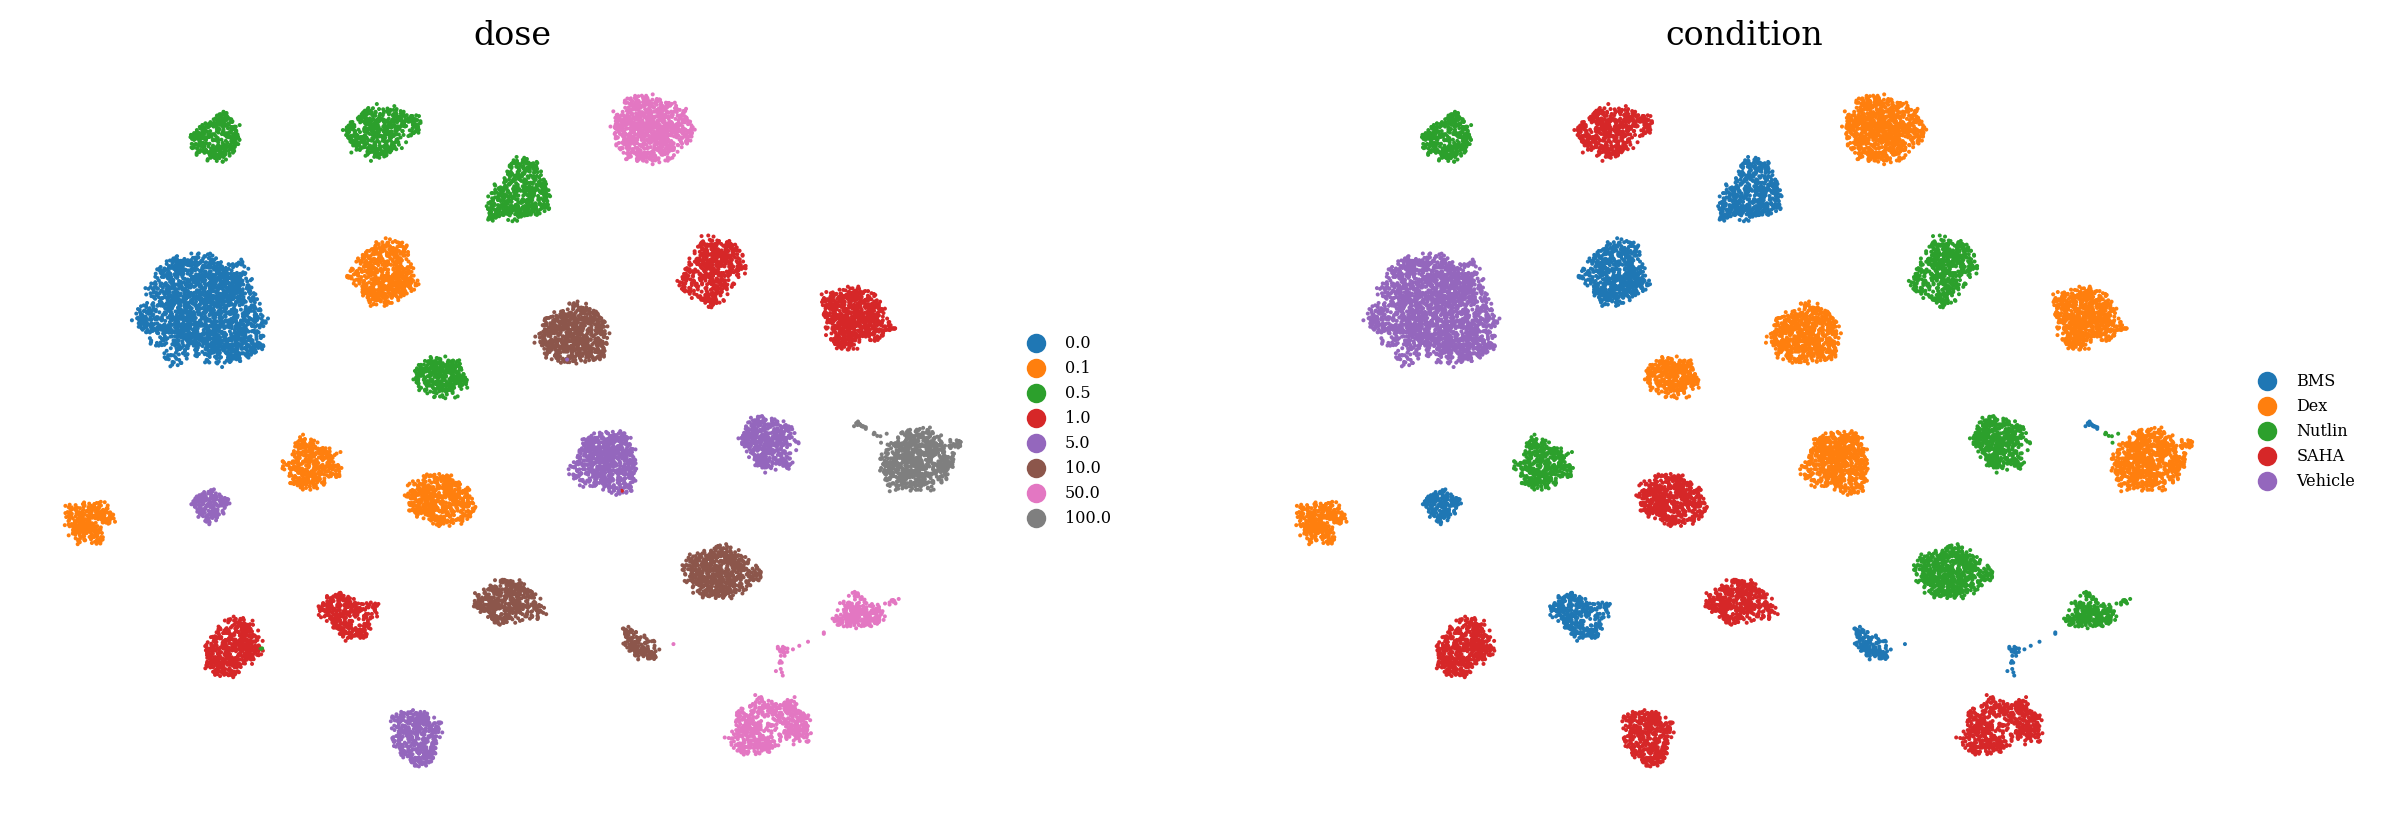

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

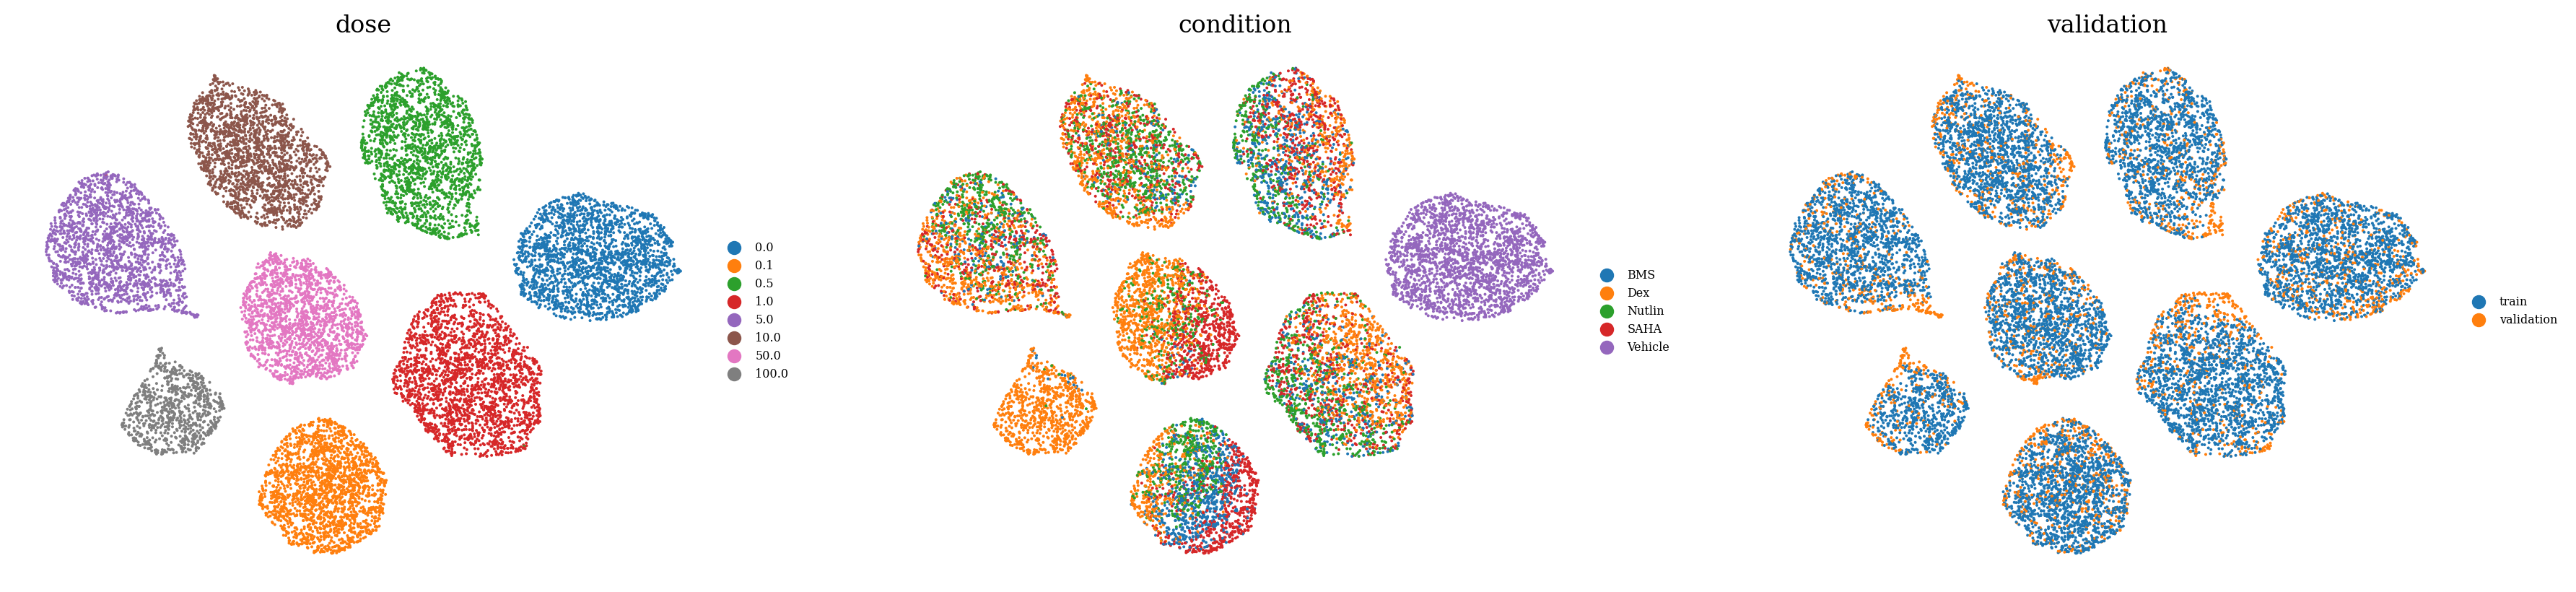

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

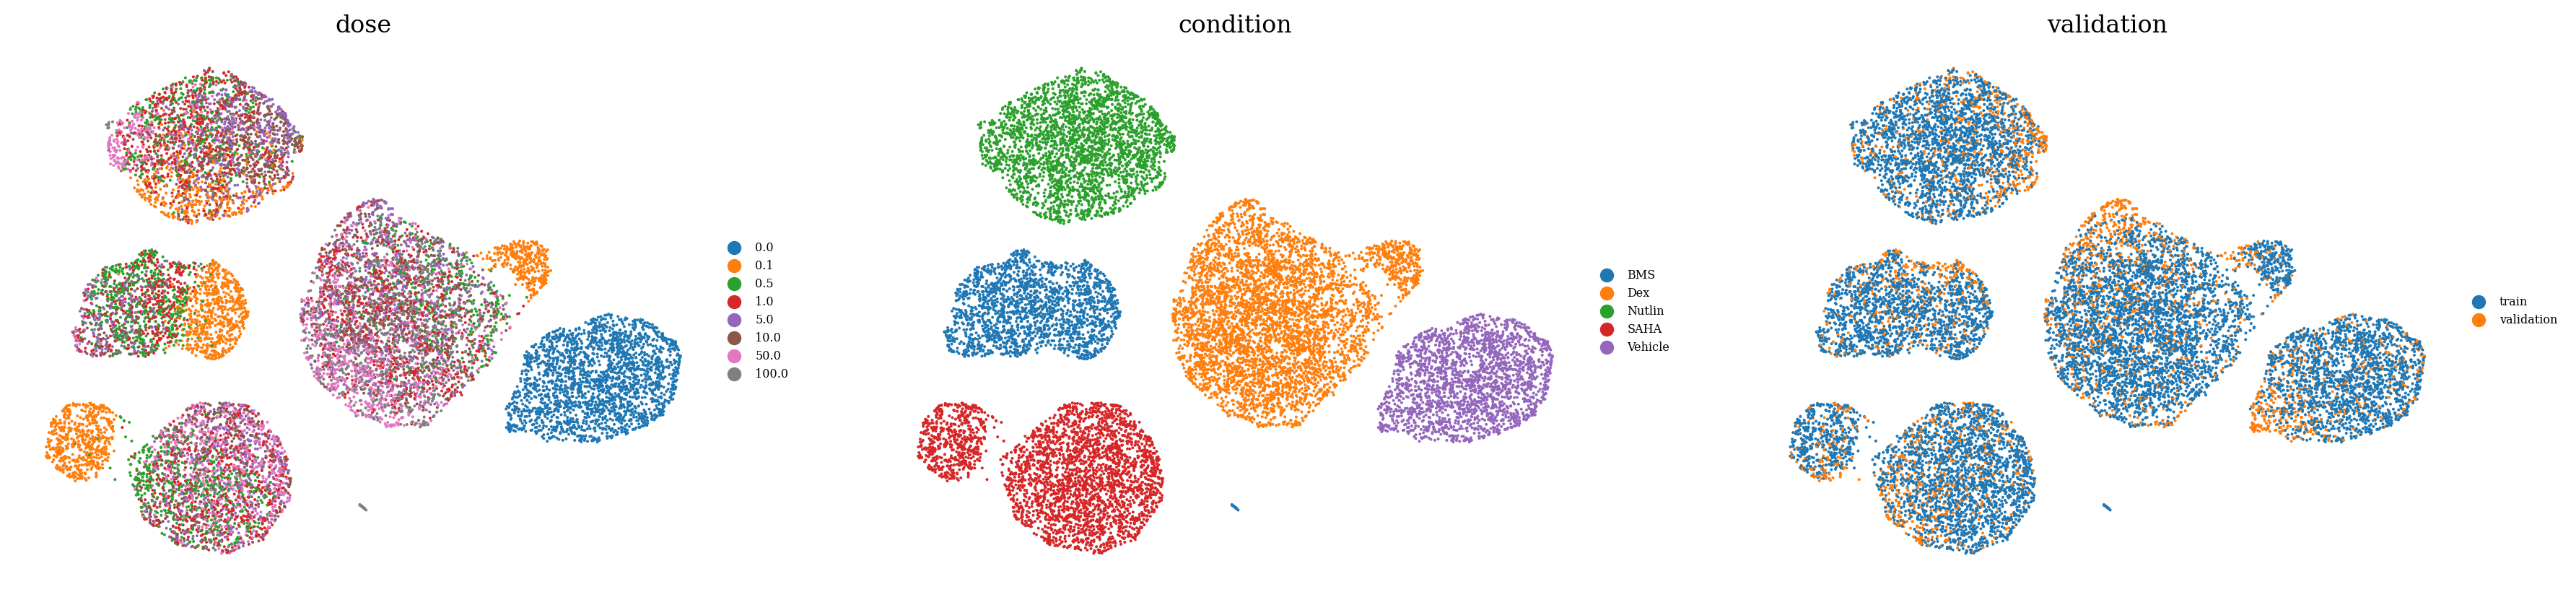

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )